For learning purpose I am implementing word2vec using tf

In [1]:
import numpy as np
import tensorflow as tf

from nltk import word_tokenize
from keras.utils import to_categorical

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
corpus_raw= 'He is the king. The king is royal. She is the royal queen'

corpus_raw=corpus_raw.lower()

to get unique words for vocabulary

In [3]:
words = [word for word in word_tokenize(corpus_raw) if word != '.'] #ignoring DOT

In [4]:
words = set(words)

vocab_size = len(words)

word2int = {o:i for i,o in enumerate(words)};
int2word = {i:o for i,o in enumerate(words)};

In [5]:
sentences =[sentence.split() for sentence in corpus_raw.split('.')]

In [6]:
sentences

[['he', 'is', 'the', 'king'],
 ['the', 'king', 'is', 'royal'],
 ['she', 'is', 'the', 'royal', 'queen']]

This is to get bi-grams for training

In [7]:
data=[]

WIN_LEN =2;

for sentence in sentences :
    for word_idx, word in enumerate(sentence):
        for nb_word in sentence[max(0,word_idx-WIN_LEN) : min(word_idx
                    +WIN_LEN,len(sentence))+1]:
            if nb_word != word:
                data.append([word,nb_word])
        

In [8]:
data[0:6]

[['he', 'is'],
 ['he', 'the'],
 ['is', 'he'],
 ['is', 'the'],
 ['is', 'king'],
 ['the', 'he']]

In [9]:
x_train = np.array([to_categorical(word2int[a[0]],vocab_size) for a in data])
y_train = np.array([to_categorical(word2int[a[1]],vocab_size) for a in data])

In [10]:
x_train[0:6]

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [11]:
y_train[0:6]

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [12]:
x_train.shape,y_train.shape

((34, 7), (34, 7))

Writing tensorflow model to train the data

In [13]:
x=tf.placeholder(tf.float32,shape=(None,vocab_size),name='input_word')
y=tf.placeholder(tf.float32,shape=(None,vocab_size),name='pred_word')

In [14]:
x[0].shape

TensorShape([Dimension(7)])

In [15]:
EMB_DIM = 5; # This variable changes based on our vocab_size
#This is we are giving to the next following layer because the output of 
#this layer is where we capture embeddings
# Output = x*W1+b1

W1=tf.Variable(tf.random_normal([vocab_size,EMB_DIM]),name='W1')
b1=tf.Variable(tf.random_normal([EMB_DIM]),name='b1')

hidden_layer = tf.add(tf.matmul(x,W1),b1)

In [16]:
W1,b1,hidden_layer

(<tf.Variable 'W1:0' shape=(7, 5) dtype=float32_ref>,
 <tf.Variable 'b1:0' shape=(5,) dtype=float32_ref>,
 <tf.Tensor 'Add:0' shape=(?, 5) dtype=float32>)

The following layer is for predictions output/target layer

In [17]:
W2=tf.Variable(tf.random_normal([EMB_DIM,vocab_size]),name='W2')
b2=tf.Variable(tf.random_normal([vocab_size]),name='b2')

prediction_layer = tf.nn.softmax(tf.add(tf.matmul(hidden_layer,W2),b2))

In [18]:
W2,b2,prediction_layer

(<tf.Variable 'W2:0' shape=(5, 7) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(7,) dtype=float32_ref>,
 <tf.Tensor 'Softmax:0' shape=(?, 7) dtype=float32>)

Let's train

In [29]:
sess=tf.Session()

init=tf.global_variables_initializer()

sess.run(init)

loss = tf.nn.softmax_cross_entropy_with_logits(logits=prediction_layer,labels=y)

model = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
iters = 10000;

for _ in range(iters):
    sess.run(model,feed_dict={x:x_train,y:y_train})
    print('loss : ',sess.run(loss,feed_dict={x:x_train,y:y_train}))

loss :  [1.2387681 2.1489522 2.0024362 2.1139998 1.8654667 2.1357126 1.1960721
 2.1438468 1.4241042 2.1193254 2.1438468 1.1960721 2.1193254 1.4241042
 2.084382  2.1139998 1.8654667 2.111382  2.1065187 1.2685454 1.1860045
 2.1602857 2.113967  2.1139998 2.111382  2.1581566 1.1960721 2.1581852
 2.157744  1.2685454 2.1426706 2.129144  2.1610668 2.161129 ]
loss :  [1.2725422 2.1425624 1.992232  2.106955  1.6664422 2.132295  1.204913
 2.1325843 1.3412135 2.1303387 2.1325843 1.204913  2.1303387 1.3412135
 2.1072183 2.106955  1.6664422 2.1042423 2.0938315 1.2712799 1.1868708
 2.1600802 2.1071386 2.106955  2.1042423 2.1561828 1.204913  2.1562033
 2.1557393 1.2712799 2.1421635 2.1294816 2.1597118 2.1597958]
loss :  [1.3065292 2.1369417 2.016684  2.1136632 1.4950666 2.131033  1.2132647
 2.1201057 1.3110197 2.1352801 2.1201057 1.2132647 2.1352801 1.3110197
 2.1175852 2.1136632 1.4950666 2.111111  2.081728  1.2749114 1.1871336
 2.160022  2.1139238 2.1136632 2.111111  2.1543624 1.2132647 2.1543798
 

loss :  [1.1709669 2.1640685 2.0892122 2.113578  1.6350844 2.1263762 1.3414257
 1.9311806 1.1708144 2.1641052 1.9311806 1.3414257 2.1641052 1.1708144
 2.1598954 2.113578  1.6350844 1.6223345 2.1539576 1.1774125 1.1668992
 2.1650474 2.1125464 2.113578  1.6223345 2.1325455 1.3414257 2.1324158
 2.1321394 1.1774125 2.1624851 2.1610808 2.1130822 2.1063695]
loss :  [1.1708899 2.1640868 2.0897527 2.1136212 1.6348972 2.1264415 1.3415432
 1.930953  1.1707666 2.164117  1.930953  1.3415432 2.164117  1.1707666
 2.159931  2.1136212 1.6348972 1.6220317 2.1541004 1.1772604 1.1668807
 2.1650524 2.1126041 2.1136212 1.6220317 2.1325326 1.3415432 2.132402
 2.1321292 1.1772604 2.1625218 2.1611364 2.113093  2.1062357]
loss :  [1.1708148 2.164105  2.0902731 2.113663  1.6347234 2.1265035 1.3416606
 1.9307286 1.1707207 2.164128  1.9307286 1.3416606 2.164128  1.1707207
 2.1599636 2.113663  1.6347234 1.621733  2.15424   1.177113  1.1668622
 2.1650567 2.1126602 2.113663  1.621733  2.1325192 1.3416606 2.1323876
 

loss :  [1.1665246 2.1651516 2.11237   2.1155849 1.6189911 2.1294265 1.3477702
 1.9208518 1.1763059 2.1627932 1.9208518 1.3477702 2.1627932 1.1763059
 2.1498249 2.1155849 1.6189911 1.6163951 2.1640959 1.168249  1.1657963
 2.165328  2.1154928 2.1155849 1.6163951 2.131793  1.3477702 2.129935
 2.1314993 1.168249  2.1647258 2.1644826 2.1635315 1.1731958]
loss :  [1.1665183 2.165153  2.1123922 2.1155868 1.618965  2.129441  1.3478035
 1.9207808 1.1762254 2.1628125 1.9207808 1.3478035 2.1628125 1.1762254
 2.1499395 2.1155868 1.618965  1.6164019 2.164108  1.1682196 1.1657941
 2.1653285 2.1154952 2.1155868 1.6164019 2.13179   1.3478035 2.1299417
 2.1314979 1.1682196 2.164733  2.164492  2.1635513 1.1731138]
loss :  [1.1665121 2.1651545 2.112414  2.1155887 1.6189395 2.1294556 1.347836
 1.9207109 1.1761459 2.1628313 1.9207109 1.347836  2.1628313 1.1761459
 2.150052  2.1155887 1.6189395 1.6164083 2.1641197 1.1681907 1.165792
 2.1653292 2.1154976 2.1155887 1.6164083 2.1317868 1.347836  2.1299484
 2.

loss :  [1.1660798 2.1652606 2.1140077 2.115733  1.6174048 2.1305041 1.3497455
 1.9161875 1.1710218 2.1640587 1.9161875 1.3497455 2.1640587 1.1710218
 2.157351  2.115733  1.6174048 1.6165074 2.1648161 1.1665618 1.1656423
 2.1653671 2.1156783 2.115733  1.6165074 2.1316288 1.3497455 2.1305547
 2.1314597 1.1665618 2.1651406 2.1650338 2.1646678 1.1685057]
loss :  [1.1660779 2.165261  2.1140146 2.1157336 1.6173998 2.1305082 1.3497518
 1.9161706 1.1710026 2.1640637 1.9161706 1.3497518 2.1640637 1.1710026
 2.1573792 2.1157336 1.6173998 1.6165062 2.1648183 1.1665565 1.1656418
 2.1653671 2.1156793 2.1157336 1.6165062 2.1316283 1.3497518 2.1305575
 2.1314597 1.1665565 2.1651418 2.1650352 2.1646714 1.168491 ]
loss :  [1.1660762 2.1652615 2.114021  2.115734  1.6173939 2.1305125 1.3497585
 1.9161536 1.1709833 2.1640682 1.9161536 1.3497585 2.1640682 1.1709833
 2.1574063 2.115734  1.6173939 1.6165057 2.164821  1.1665514 1.1656411
 2.1653674 2.11568   2.115734  1.6165057 2.1316278 1.3497585 2.1305604


 2.1314735 1.166127  2.165248  2.1651807 2.1649625 1.1672989]
loss :  [1.1659068 2.1653032 2.1146238 2.1157937 1.6169299 2.1308823 1.3502928
 1.9146919 1.1692965 2.1644766 1.9146919 1.3502928 2.1644766 1.1692965
 2.1598244 2.1157937 1.6169299 1.6163958 2.1650198 1.166125  1.1655855
 2.1653814 2.1157541 2.1157937 1.6163958 2.131592  1.3502928 2.1308403
 2.1314735 1.166125  2.1652484 2.1651814 2.1649637 1.1672932]
loss :  [1.165906  2.1653035 2.1146271 2.1157942 1.6169275 2.1308842 1.3502955
 1.9146843 1.1692874 2.1644788 1.9146843 1.3502955 2.1644788 1.1692874
 2.159837  2.1157942 1.6169275 1.6163949 2.1650207 1.1661229 1.1655852
 2.1653814 2.1157544 2.1157942 1.6163949 2.1315918 1.3502955 2.130842
 2.1314738 1.1661229 2.1652489 2.165182  2.1649652 1.1672873]
loss :  [1.1659051 2.1653037 2.1146302 2.1157944 1.6169248 2.130886  1.3502982
 1.9146768 1.1692789 2.164481  1.9146768 1.3502982 2.164481  1.1692789
 2.1598496 2.1157944 1.6169248 1.6163945 2.1650217 1.1661208 1.1655848
 2.1653814

loss :  [1.1658013 2.165329  2.1149735 2.11583   1.616673  2.131083  1.3505676
 1.9138958 1.1683457 2.1647077 1.9138958 1.3505676 2.1647077 1.1683457
 2.1611912 2.11583   1.616673  1.6163049 2.1651251 1.1659124 1.1655517
 2.16539   2.1157994 2.11583   1.6163049 2.1315756 1.3505676 2.1310134
 2.1314871 1.1659124 2.1653008 2.165254  2.1651075 1.1667055]
loss :  [1.1658008 2.1653292 2.1149755 2.1158304 1.6166717 2.131084  1.3505687
 1.913892  1.1683408 2.1647089 1.913892  1.3505687 2.1647089 1.1683408
 2.1611981 2.1158304 1.6166717 1.6163045 2.1651256 1.1659114 1.1655515
 2.16539   2.1157997 2.1158304 1.6163045 2.1315756 1.3505687 2.131014
 2.1314871 1.1659114 2.165301  2.1652546 2.1651082 1.1667025]
loss :  [1.1658003 2.1653295 2.1149771 2.1158304 1.6166704 2.1310852 1.35057
 1.9138882 1.168336  2.16471   1.9138882 1.35057   2.16471   1.168336
 2.1612053 2.1158304 1.6166704 1.6163037 2.165126  1.1659105 1.1655513
 2.16539   2.1158    2.1158304 1.6163037 2.1315753 1.35057   2.131015
 2.13

loss :  [1.165741  2.1653438 2.1151614 2.1158504 1.6165376 2.1311855 1.3507049
 1.9134841 1.1678356 2.1648316 1.9134841 1.3507049 2.1648316 1.1678356
 2.1619256 2.1158504 1.6165376 1.6162475 2.1651795 1.1658075 1.1655326
 2.1653948 2.115825  2.1158504 1.6162475 2.131568  1.3507049 2.1311092
 2.1314957 1.1658075 2.1653268 2.1652904 2.165178  1.1664176]
loss :  [1.1657407 2.165344  2.1151626 2.1158507 1.6165357 2.131186  1.3507062
 1.913481  1.1678326 2.1648326 1.913481  1.3507062 2.1648326 1.1678326
 2.1619303 2.1158507 1.6165357 1.6162484 2.16518   1.165807  1.1655324
 2.1653945 2.1158252 2.1158507 1.6162484 2.1315677 1.3507062 2.1311097
 2.1314957 1.165807  2.165327  2.1652906 2.1651785 1.1664158]
loss :  [1.1657404 2.1653442 2.1151638 2.1158507 1.6165352 2.1311867 1.3507067
 1.9134789 1.1678293 2.1648335 1.9134789 1.3507067 2.1648335 1.1678293
 2.161935  2.1158507 1.6165352 1.6162474 2.1651802 1.1658063 1.1655324
 2.1653948 2.1158252 2.1158507 1.6162474 2.1315677 1.3507067 2.1311102


 2.1315022 1.1657407 2.1653433 2.1653132 2.1652226 1.1662356]
loss :  [1.1656983 2.1653543 2.115288  2.1158645 1.6164453 2.1312516 1.3507946
 1.9132116 1.1674893 2.1649163 1.9132116 1.3507946 2.1649163 1.1674893
 2.1624255 2.1158645 1.6164453 1.6162066 2.1652157 1.1657403 1.1655191
 2.1653981 2.1158423 2.1158645 1.6162066 2.131563  1.3507946 2.1311748
 2.131502  1.1657403 2.1653433 2.1653135 2.165223  1.1662343]
loss :  [1.165698  2.1653545 2.115289  2.1158648 1.6164446 2.131252  1.3507953
 1.9132096 1.1674868 2.164917  1.9132096 1.3507953 2.164917  1.1674868
 2.1624289 2.1158648 1.6164446 1.6162069 2.165216  1.1657398 1.1655188
 2.1653981 2.1158428 2.1158648 1.6162069 2.1315627 1.3507953 2.1311753
 2.131502  1.1657398 2.1653435 2.1653137 2.1652231 1.1662331]
loss :  [1.1656977 2.1653545 2.1152897 2.1158648 1.6164442 2.1312525 1.350796
 1.9132078 1.1674844 2.1649175 1.9132078 1.350796  2.1649175 1.1674844
 2.1624322 2.1158648 1.6164442 1.616206  2.1652164 1.1657394 1.1655188
 2.1653981

loss :  [1.1656647 2.1653626 2.1153834 2.1158755 1.6163763 2.1313    1.3508605
 1.9130094 1.1672254 2.164981  1.9130094 1.3508605 2.164981  1.1672254
 2.1628065 2.1158755 1.6163763 1.6161737 2.165243  1.1656914 1.1655085
 2.1654007 2.1158562 2.1158755 1.6161737 2.1315594 1.3508605 2.131225
 2.131507  1.1656914 2.1653554 2.1653304 2.1652555 1.1661019]
loss :  [1.1656646 2.1653626 2.115384  2.1158757 1.6163751 2.1313004 1.350861
 1.913008  1.1672235 2.164981  1.913008  1.350861  2.164981  1.1672235
 2.162809  2.1158757 1.6163751 1.6161745 2.1652431 1.165691  1.1655083
 2.1654007 2.1158564 2.1158757 1.6161745 2.1315594 1.350861  2.1312256
 2.1315072 1.165691  2.1653557 2.1653306 2.1652558 1.1661009]
loss :  [1.1656642 2.1653628 2.1153846 2.1158755 1.6163753 2.1313007 1.3508613
 1.9130068 1.1672215 2.1649814 1.9130068 1.3508613 2.1649814 1.1672215
 2.1628115 2.1158755 1.6163753 1.6161733 2.1652436 1.1656909 1.1655082
 2.1654007 2.1158562 2.1158755 1.6161733 2.1315594 1.3508613 2.1312258
 2

loss :  [1.1656353 2.16537   2.1154635 2.115885  1.6163175 2.1313393 1.3509147
 1.9128414 1.1670008 2.1650357 1.9128414 1.3509147 2.1650357 1.1670008
 2.1631308 2.115885  1.6163175 1.616146  2.165266  1.1656514 1.1654992
 2.1654031 2.115868  2.115885  1.616146  2.1315567 1.3509147 2.1312678
 2.1315114 1.1656514 2.1653655 2.1653445 2.1652818 1.1659944]
loss :  [1.1656352 2.16537   2.1154637 2.1158848 1.616317  2.1313396 1.350915
 1.9128404 1.1669996 2.165036  1.9128404 1.350915  2.165036  1.1669996
 2.1631327 2.1158848 1.616317  1.6161455 2.165266  1.1656512 1.165499
 2.165403  2.1158679 2.1158848 1.6161455 2.1315565 1.350915  2.131268
 2.1315114 1.1656512 2.1653655 2.1653445 2.165282  1.1659939]
loss :  [1.165635  2.16537   2.1154644 2.115885  1.6163164 2.1313398 1.3509157
 1.9128389 1.1669981 2.1650362 1.9128389 1.3509157 2.1650362 1.1669981
 2.1631346 2.115885  1.6163164 1.6161458 2.165266  1.1656511 1.165499
 2.1654031 2.115868  2.115885  1.6161458 2.1315565 1.3509157 2.131268
 2.13

loss :  [1.165612  2.1653757 2.1155252 2.1158922 1.6162722 2.1313689 1.350956
 1.9127123 1.1668243 2.1650789 1.9127123 1.350956  2.1650789 1.1668243
 2.1633863 2.1158922 1.6162722 1.6161226 2.1652837 1.165621  1.1654916
 2.165405  2.1158772 2.1158922 1.6161226 2.1315544 1.350956  2.131301
 2.1315148 1.165621  2.1653728 2.165355  2.1653016 1.1659136]
loss :  [1.1656116 2.1653757 2.1155257 2.1158924 1.6162711 2.131369  1.3509561
 1.9127117 1.1668233 2.165079  1.9127117 1.3509561 2.165079  1.1668233
 2.1633878 2.1158924 1.6162711 1.6161234 2.1652837 1.1656208 1.1654916
 2.165405  2.1158772 2.1158924 1.6161234 2.1315544 1.3509561 2.1313012
 2.1315148 1.1656208 2.1653728 2.165355  2.1653016 1.1659131]
loss :  [1.1656115 2.1653757 2.1155262 2.1158924 1.6162716 2.131369  1.3509567
 1.9127107 1.1668221 2.1650794 1.9127107 1.3509567 2.1650794 1.1668221
 2.1633892 2.1158924 1.6162716 1.6161225 2.165284  1.1656207 1.1654916
 2.165405  2.1158772 2.1158924 1.6161225 2.1315544 1.3509567 2.1313014
 2

loss :  [1.165593  2.1653802 2.1155736 2.1158981 1.6162361 2.1313915 1.3509881
 1.9126123 1.1666846 2.1651127 1.9126123 1.3509881 2.1651127 1.1666846
 2.1635878 2.1158981 1.6162361 1.6161051 2.1652975 1.1655978 1.1654857
 2.1654065 2.1158845 2.1158981 1.6161051 2.1315527 1.3509881 2.1313272
 2.1315174 1.1655978 2.1653788 2.1653628 2.1653168 1.1658523]
loss :  [1.1655929 2.1653802 2.115574  2.1158981 1.6162361 2.1313915 1.3509883
 1.9126117 1.1666839 2.165113  1.9126117 1.3509883 2.165113  1.1666839
 2.1635892 2.1158981 1.6162361 1.6161046 2.1652975 1.1655977 1.1654856
 2.1654065 2.1158845 2.1158981 1.6161046 2.1315527 1.3509883 2.1313274
 2.1315176 1.1655977 2.1653788 2.1653628 2.1653168 1.1658518]
loss :  [1.1655928 2.1653802 2.1155741 2.1158981 1.6162357 2.1313918 1.3509884
 1.9126112 1.1666832 2.1651132 1.9126112 1.3509884 2.1651132 1.1666832
 2.1635904 2.1158981 1.6162357 1.6161047 2.1652977 1.1655976 1.1654855
 2.1654065 2.1158845 2.1158981 1.6161047 2.1315527 1.3509884 2.1313276


loss :  [1.1655769 2.165384  2.1156135 2.115903  1.6162065 2.1314096 1.3510144
 1.9125302 1.1665676 2.1651416 1.9125302 1.3510144 2.1651416 1.1665676
 2.1637576 2.115903  1.6162065 1.6160897 2.1653092 1.1655788 1.1654805
 2.1654077 2.1158907 2.115903  1.6160897 2.1315515 1.3510144 2.131349
 2.1315198 1.1655788 2.1653833 2.1653695 2.165329  1.1658024]
loss :  [1.1655769 2.1653843 2.1156137 2.1159031 1.6162064 2.1314096 1.3510146
 1.9125295 1.166567  2.1651416 1.9125295 1.3510146 2.1651416 1.166567
 2.1637588 2.1159031 1.6162064 1.6160896 2.1653094 1.1655787 1.1654805
 2.1654077 2.1158907 2.1159031 1.6160896 2.1315515 1.3510146 2.131349
 2.1315198 1.1655787 2.1653836 2.1653695 2.165329  1.165802 ]
loss :  [1.1655768 2.1653843 2.115614  2.115903  1.6162059 2.13141   1.3510147
 1.9125291 1.1665661 2.1651418 1.9125291 1.3510147 2.1651418 1.1665661
 2.1637597 2.115903  1.6162059 1.6160896 2.1653094 1.1655786 1.1654805
 2.1654077 2.1158907 2.115903  1.6160896 2.1315513 1.3510147 2.131349
 2.1

loss :  [1.165564  2.1653874 2.1156452 2.115907  1.6161829 2.131424  1.3510354
 1.9124646 1.1664729 2.1651647 1.9124646 1.3510354 2.1651647 1.1664729
 2.1638947 2.115907  1.6161829 1.6160771 2.1653185 1.1655637 1.1654762
 2.1654086 2.1158955 2.115907  1.6160771 2.1315503 1.3510354 2.1313665
 2.1315217 1.1655637 2.1653872 2.1653748 2.1653385 1.1657631]
loss :  [1.165564  2.1653874 2.1156454 2.1159067 1.6161827 2.131424  1.3510358
 1.912464  1.1664723 2.1651647 1.912464  1.3510358 2.1651647 1.1664723
 2.1638954 2.1159067 1.6161827 1.6160768 2.1653185 1.1655636 1.1654762
 2.1654086 2.1158955 2.1159067 1.6160768 2.1315503 1.3510358 2.1313667
 2.1315217 1.1655636 2.1653872 2.1653748 2.1653385 1.165763 ]
loss :  [1.1655638 2.1653874 2.1156456 2.115907  1.6161829 2.1314242 1.3510358
 1.9124637 1.1664718 2.165165  1.9124637 1.3510358 2.165165  1.1664718
 2.163896  2.115907  1.6161829 1.6160766 2.1653185 1.1655636 1.1654762
 2.1654086 2.1158957 2.115907  1.6160766 2.1315503 1.3510358 2.1313667


loss :  [1.1655531 2.16539   2.1156716 2.11591   1.6161634 2.1314356 1.3510528
 1.9124103 1.1663932 2.1651843 1.9124103 1.3510528 2.1651843 1.1663932
 2.1640103 2.11591   1.6161634 1.6160661 2.1653264 1.1655513 1.1654725
 2.1654096 2.1158996 2.11591   1.6160661 2.1315496 1.3510528 2.131381
 2.1315234 1.1655513 2.1653903 2.165379  2.1653461 1.1657311]
loss :  [1.1655527 2.16539   2.1156716 2.11591   1.6161618 2.1314356 1.351053
 1.9124099 1.1663926 2.1651843 1.9124099 1.351053  2.1651843 1.1663926
 2.164011  2.11591   1.6161618 1.6160674 2.1653264 1.1655513 1.1654725
 2.1654096 2.1158996 2.11591   1.6160674 2.1315496 1.351053  2.1313813
 2.1315234 1.1655513 2.1653903 2.165379  2.1653464 1.1657308]
loss :  [1.1655527 2.16539   2.115672  2.1159103 1.6161635 2.1314356 1.3510528
 1.9124098 1.1663921 2.1651843 1.9124098 1.3510528 2.1651843 1.1663921
 2.1640117 2.1159103 1.6161635 1.6160657 2.1653266 1.1655512 1.1654725
 2.1654096 2.1158998 2.1159103 1.6160657 2.1315494 1.3510528 2.1313813
 2

loss :  [1.1655433 2.1653924 2.115694  2.115913  1.6161458 2.1314454 1.3510675
 1.9123639 1.1663244 2.1652012 1.9123639 1.3510675 2.1652012 1.1663244
 2.1641102 2.115913  1.6161458 1.6160576 2.1653333 1.1655409 1.1654695
 2.1654105 2.1159034 2.115913  1.6160576 2.131549  1.3510675 2.1313934
 2.1315246 1.1655409 2.1653929 2.1653826 2.165353  1.1657041]
loss :  [1.1655433 2.1653924 2.1156943 2.1159132 1.6161461 2.1314454 1.3510674
 1.9123639 1.1663238 2.1652012 1.9123639 1.3510674 2.1652012 1.1663238
 2.1641107 2.1159132 1.6161461 1.6160574 2.1653333 1.1655408 1.1654695
 2.1654105 2.1159034 2.1159132 1.6160574 2.131549  1.3510674 2.1313937
 2.1315246 1.1655408 2.1653929 2.1653826 2.165353  1.1657039]
loss :  [1.1655433 2.1653924 2.1156945 2.1159132 1.616146  2.1314454 1.3510678
 1.9123633 1.1663234 2.1652012 1.9123633 1.3510678 2.1652012 1.1663234
 2.1641114 2.1159132 1.616146  1.6160573 2.1653333 1.1655408 1.1654694
 2.1654105 2.1159034 2.1159132 1.6160573 2.131549  1.3510678 2.1313937


loss :  [1.1655365 2.1653943 2.1157103 2.115915  1.6161329 2.131452  1.3510782
 1.9123306 1.1662745 2.165213  1.9123306 1.3510782 2.165213  1.1662745
 2.1641822 2.115915  1.6161329 1.6160518 2.165338  1.1655334 1.1654671
 2.165411  2.1159058 2.115915  1.6160518 2.1315482 1.3510782 2.1314025
 2.1315255 1.1655334 2.1653948 2.1653852 2.1653576 1.1656848]
loss :  [1.1655364 2.1653943 2.1157105 2.115915  1.6161343 2.1314523 1.351078
 1.9123307 1.1662742 2.1652133 1.9123307 1.351078  2.1652133 1.1662742
 2.1641827 2.115915  1.6161343 1.6160504 2.165338  1.1655333 1.165467
 2.165411  2.1159058 2.115915  1.6160504 2.1315482 1.351078  2.1314027
 2.1315255 1.1655333 2.1653948 2.1653852 2.1653576 1.1656847]
loss :  [1.1655364 2.1653943 2.1157105 2.115915  1.6161332 2.1314523 1.3510785
 1.91233   1.1662737 2.1652133 1.91233   1.3510785 2.1652133 1.1662737
 2.1641834 2.115915  1.6161332 1.6160512 2.165338  1.1655332 1.165467
 2.165411  2.115906  2.115915  1.6160512 2.1315482 1.3510785 2.1314027
 2.

loss :  [1.1655289 2.165396  2.1157274 2.1159172 1.6161202 2.1314595 1.3510892
 1.912296  1.1662211 2.1652262 1.912296  1.3510892 2.1652262 1.1662211
 2.1642597 2.1159172 1.6161202 1.6160444 2.1653433 1.1655253 1.1654646
 2.1654117 2.1159086 2.1159172 1.6160444 2.1315477 1.3510892 2.131412
 2.1315267 1.1655253 2.1653967 2.1653879 2.1653628 1.1656647]
loss :  [1.1655288 2.165396  2.1157274 2.1159172 1.6161203 2.1314595 1.3510896
 1.9122955 1.1662208 2.1652265 1.9122955 1.3510896 2.1652265 1.1662208
 2.1642601 2.1159172 1.6161203 1.616044  2.1653433 1.1655253 1.1654646
 2.1654117 2.1159086 2.1159172 1.616044  2.1315477 1.3510896 2.131412
 2.1315265 1.1655253 2.1653967 2.1653879 2.1653628 1.1656646]
loss :  [1.1655288 2.165396  2.1157277 2.1159174 1.6161207 2.1314595 1.3510895
 1.9122953 1.1662205 2.1652265 1.9122953 1.3510895 2.1652265 1.1662205
 2.1642606 2.1159174 1.6161207 1.6160439 2.1653433 1.1655252 1.1654646
 2.1654117 2.1159086 2.1159174 1.6160439 2.1315477 1.3510895 2.1314123
 2

 2.1315274 1.1655191 2.1653984 2.16539   2.1653666 1.1656483]
loss :  [1.1655227 2.1653974 2.1157413 2.115919  1.61611   2.1314652 1.3510987
 1.9122669 1.1661772 2.165237  1.9122669 1.3510987 2.165237  1.1661772
 2.1643233 2.115919  1.61611   1.6160384 2.1653476 1.1655191 1.1654626
 2.1654122 2.115911  2.115919  1.6160384 2.131547  1.3510987 2.13142
 2.1315274 1.1655191 2.1653984 2.16539   2.1653666 1.1656482]
loss :  [1.1655227 2.1653976 2.1157413 2.115919  1.6161096 2.1314654 1.3510987
 1.912267  1.1661769 2.1652372 1.912267  1.3510987 2.1652372 1.1661769
 2.1643238 2.115919  1.6161096 1.6160386 2.1653476 1.1655189 1.1654625
 2.1654122 2.115911  2.115919  1.6160386 2.1315472 1.3510987 2.1314201
 2.1315274 1.1655189 2.1653984 2.16539   2.1653666 1.1656482]
loss :  [1.1655227 2.1653976 2.1157415 2.115919  1.6161101 2.1314654 1.3510988
 1.9122667 1.1661767 2.1652372 1.9122667 1.3510988 2.1652372 1.1661767
 2.1643243 2.115919  1.6161101 1.6160381 2.1653476 1.1655189 1.1654625
 2.1654122 

loss :  [1.1655172 2.1653988 2.1157537 2.1159205 1.6161002 2.1314704 1.351107
 1.9122416 1.1661379 2.1652467 1.9122416 1.351107  2.1652467 1.1661379
 2.1643806 2.1159205 1.6161002 1.6160334 2.1653514 1.1655133 1.1654606
 2.1654127 2.115913  2.1159205 1.6160334 2.131547  1.351107  2.131427
 2.1315284 1.1655133 2.1653996 2.165392  2.1653702 1.1656339]
loss :  [1.1655172 2.1653988 2.1157537 2.1159205 1.6161004 2.1314704 1.3511065
 1.9122417 1.1661376 2.1652467 1.9122417 1.3511065 2.1652467 1.1661376
 2.164381  2.1159205 1.6161004 1.6160332 2.1653514 1.1655133 1.1654606
 2.1654127 2.115913  2.1159205 1.6160332 2.1315467 1.3511065 2.1314268
 2.1315281 1.1655133 2.1653996 2.165392  2.1653702 1.1656339]
loss :  [1.1655172 2.165399  2.1157537 2.1159205 1.6161003 2.1314704 1.3511069
 1.9122413 1.1661375 2.165247  1.9122413 1.3511069 2.165247  1.1661375
 2.1643813 2.1159205 1.6161003 1.6160331 2.1653514 1.1655133 1.1654606
 2.1654127 2.115913  2.1159205 1.6160331 2.1315467 1.3511069 2.131427
 2.

loss :  [1.1655118 2.1654    2.1157656 2.1159222 1.6160926 2.1314752 1.3511143
 1.9122176 1.1660999 2.165256  1.9122176 1.3511143 2.165256  1.1660999
 2.1644356 2.1159222 1.6160926 1.6160272 2.165355  1.1655079 1.1654588
 2.1654131 2.1159148 2.1159222 1.6160272 2.1315463 1.3511143 2.1314335
 2.1315289 1.1655079 2.165401  2.1653938 2.1653736 1.1656204]
loss :  [1.1655118 2.1654    2.1157656 2.1159222 1.6160904 2.1314752 1.351115
 1.9122168 1.1660998 2.165256  1.9122168 1.351115  2.165256  1.1660998
 2.164436  2.1159222 1.6160904 1.6160294 2.165355  1.1655079 1.1654588
 2.1654131 2.1159148 2.1159222 1.6160294 2.1315463 1.351115  2.1314335
 2.1315289 1.1655079 2.165401  2.1653938 2.1653736 1.1656202]
loss :  [1.1655117 2.1654    2.1157656 2.1159222 1.616092  2.1314754 1.3511142
 1.9122176 1.1660993 2.165256  1.9122176 1.3511142 2.165256  1.1660993
 2.1644363 2.1159222 1.616092  1.6160276 2.1653552 1.1655077 1.1654588
 2.1654131 2.1159148 2.1159222 1.6160276 2.1315465 1.3511142 2.1314337
 

loss :  [1.1655071 2.1654012 2.1157756 2.1159234 1.6160841 2.1314793 1.3511213
 1.9121966 1.166067  2.1652641 1.9121966 1.3511213 2.1652641 1.166067
 2.1644835 2.1159234 1.6160841 1.6160235 2.165358  1.1655031 1.165457
 2.1654134 2.1159165 2.1159234 1.6160235 2.131546  1.3511213 2.1314392
 2.1315296 1.1655031 2.1654022 2.1653955 2.1653764 1.1656086]
loss :  [1.1655071 2.1654012 2.1157756 2.1159234 1.6160827 2.1314793 1.3511213
 1.9121963 1.1660669 2.1652641 1.9121963 1.3511213 2.1652641 1.1660669
 2.1644838 2.1159234 1.6160827 1.6160245 2.1653583 1.1655031 1.165457
 2.1654134 2.1159163 2.1159234 1.6160245 2.131546  1.3511213 2.1314392
 2.1315293 1.1655031 2.1654024 2.1653955 2.1653764 1.1656086]
loss :  [1.1655071 2.1654015 2.1157758 2.1159236 1.6160843 2.1314793 1.3511215
 1.9121959 1.1660666 2.1652641 1.9121959 1.3511215 2.1652641 1.1660666
 2.164484  2.1159236 1.6160843 1.6160233 2.1653583 1.1655031 1.165457
 2.1654134 2.1159165 2.1159236 1.6160233 2.131546  1.3511215 2.1314392
 2.1

loss :  [1.1655036 2.1654022 2.1157832 2.1159244 1.6160778 2.1314824 1.3511267
 1.9121803 1.166042  2.16527   1.9121803 1.3511267 2.16527   1.166042
 2.1645195 2.1159244 1.6160778 1.6160206 2.1653607 1.1654997 1.1654558
 2.1654139 2.1159177 2.1159244 1.6160206 2.1315455 1.3511267 2.1314435
 2.1315298 1.1654997 2.1654031 2.1653967 2.1653786 1.1656   ]
loss :  [1.1655036 2.1654022 2.1157832 2.1159246 1.6160774 2.1314824 1.3511263
 1.9121805 1.1660419 2.1652703 1.9121805 1.3511263 2.1652703 1.1660419
 2.16452   2.1159246 1.6160774 1.6160212 2.1653607 1.1654997 1.1654558
 2.1654139 2.115918  2.1159246 1.6160212 2.1315455 1.3511263 2.1314435
 2.1315298 1.1654997 2.1654031 2.1653967 2.1653786 1.1656   ]
loss :  [1.1655036 2.1654022 2.1157832 2.1159246 1.616078  2.1314824 1.3511266
 1.9121803 1.1660416 2.1652703 1.9121803 1.3511266 2.1652703 1.1660416
 2.1645203 2.1159246 1.616078  1.6160203 2.1653607 1.1654997 1.1654558
 2.1654139 2.1159177 2.1159246 1.6160203 2.1315455 1.3511266 2.1314435
 

loss :  [1.1654997 2.1654031 2.1157918 2.1159258 1.6160711 2.131486  1.351132
 1.9121631 1.1660137 2.165277  1.9121631 1.351132  2.165277  1.1660137
 2.1645608 2.1159258 1.6160711 1.6160172 2.1653633 1.1654956 1.1654546
 2.1654143 2.1159194 2.1159258 1.6160172 2.1315455 1.351132  2.1314485
 2.1315305 1.1654956 2.1654038 2.165398  2.165381  1.1655902]
loss :  [1.1654997 2.1654034 2.1157918 2.1159256 1.6160712 2.131486  1.3511318
 1.9121633 1.1660136 2.1652772 1.9121633 1.3511318 2.1652772 1.1660136
 2.164561  2.1159256 1.6160712 1.6160169 2.1653633 1.1654956 1.1654546
 2.1654143 2.115919  2.1159256 1.6160169 2.1315453 1.3511318 2.1314485
 2.1315303 1.1654956 2.1654038 2.165398  2.165381  1.1655902]
loss :  [1.1654997 2.1654034 2.1157918 2.1159256 1.6160702 2.131486  1.3511323
 1.9121627 1.1660134 2.1652772 1.9121627 1.3511323 2.1652772 1.1660134
 2.1645613 2.1159256 1.6160702 1.6160177 2.1653633 1.1654956 1.1654546
 2.1654143 2.115919  2.1159256 1.6160177 2.1315453 1.3511323 2.1314485
 

loss :  [1.1654972 2.1654038 2.115797  2.1159263 1.6160674 2.1314878 1.3511354
 1.9121525 1.1659963 2.1652813 1.9121525 1.3511354 2.1652813 1.1659963
 2.164586  2.1159263 1.6160674 1.6160145 2.1653652 1.1654932 1.1654538
 2.1654146 2.11592   2.1159263 1.6160145 2.131545  1.3511354 2.1314516
 2.1315308 1.1654932 2.1654048 2.1653988 2.1653824 1.1655841]
loss :  [1.1654972 2.1654038 2.115797  2.1159263 1.6160668 2.1314878 1.3511358
 1.9121518 1.1659962 2.1652813 1.9121518 1.3511358 2.1652813 1.1659962
 2.164586  2.1159263 1.6160668 1.6160153 2.1653652 1.1654932 1.1654538
 2.1654146 2.11592   2.1159263 1.6160153 2.131545  1.3511358 2.1314516
 2.1315308 1.1654932 2.1654048 2.1653988 2.1653824 1.1655841]
loss :  [1.1654972 2.1654038 2.115797  2.1159263 1.6160674 2.1314878 1.3511358
 1.9121518 1.1659961 2.1652815 1.9121518 1.3511358 2.1652815 1.1659961
 2.1645865 2.1159263 1.6160674 1.6160145 2.1653652 1.1654932 1.1654538
 2.1654146 2.11592   2.1159263 1.6160145 2.131545  1.3511358 2.1314516


loss :  [1.1654953 2.1654043 2.1158016 2.115927  1.6160645 2.1314898 1.3511384
 1.9121432 1.1659815 2.165285  1.9121432 1.3511384 2.165285  1.1659815
 2.1646075 2.115927  1.6160645 1.6160121 2.1653664 1.1654912 1.165453
 2.1654146 2.1159208 2.115927  1.6160121 2.131545  1.3511384 2.131454
 2.131531  1.1654912 2.1654053 2.1653996 2.1653836 1.165579 ]
loss :  [1.165495  2.1654043 2.1158016 2.115927  1.6160622 2.1314898 1.3511388
 1.9121426 1.1659813 2.165285  1.9121426 1.3511388 2.165285  1.1659813
 2.1646078 2.115927  1.6160622 1.6160145 2.1653664 1.1654912 1.165453
 2.1654146 2.1159208 2.115927  1.6160145 2.131545  1.3511388 2.131454
 2.131531  1.1654912 2.1654053 2.1653996 2.1653836 1.165579 ]
loss :  [1.165495  2.1654043 2.1158016 2.115927  1.6160648 2.1314898 1.3511385
 1.912143  1.1659813 2.165285  1.912143  1.3511385 2.165285  1.1659813
 2.164608  2.115927  1.6160648 1.6160119 2.1653666 1.1654912 1.165453
 2.1654146 2.115921  2.115927  1.6160119 2.131545  1.3511385 2.131454
 2.131

loss :  [1.1654929 2.1654048 2.1158063 2.1159277 1.6160598 2.1314917 1.3511417
 1.9121332 1.1659658 2.165289  1.9121332 1.3511417 2.165289  1.1659658
 2.1646307 2.1159277 1.6160598 1.6160111 2.165368  1.1654892 1.1654521
 2.1654148 2.1159217 2.1159277 1.6160111 2.1315448 1.3511417 2.1314569
 2.1315312 1.1654892 2.1654058 2.1654003 2.165385  1.1655738]
loss :  [1.1654929 2.1654048 2.1158063 2.1159277 1.61606   2.1314917 1.3511418
 1.9121331 1.1659656 2.165289  1.9121331 1.3511418 2.165289  1.1659656
 2.164631  2.1159277 1.61606   1.6160109 2.165368  1.1654891 1.1654521
 2.1654148 2.1159217 2.1159277 1.6160109 2.1315448 1.3511418 2.1314569
 2.1315312 1.1654891 2.1654058 2.1654003 2.165385  1.1655737]
loss :  [1.1654929 2.1654048 2.1158063 2.1159277 1.6160593 2.1314914 1.3511418
 1.9121329 1.1659653 2.165289  1.9121329 1.3511418 2.165289  1.1659653
 2.164631  2.1159277 1.6160593 1.6160116 2.165368  1.1654891 1.165452
 2.1654148 2.1159217 2.1159277 1.6160116 2.1315448 1.3511418 2.1314566
 

loss :  [1.1654905 2.1654053 2.1158113 2.1159282 1.6160564 2.1314936 1.3511449
 1.912123  1.1659485 2.1652932 1.912123  1.3511449 2.1652932 1.1659485
 2.1646557 2.1159282 1.6160564 1.6160083 2.1653695 1.1654867 1.1654513
 2.165415  2.1159225 2.1159282 1.6160083 2.1315448 1.3511449 2.1314597
 2.1315317 1.1654867 2.1654062 2.165401  2.1653862 1.1655679]
loss :  [1.1654905 2.1654053 2.1158116 2.1159284 1.6160554 2.1314936 1.351145
 1.9121227 1.1659483 2.1652932 1.9121227 1.351145  2.1652932 1.1659483
 2.1646557 2.1159284 1.6160554 1.6160096 2.1653695 1.1654867 1.1654513
 2.165415  2.1159227 2.1159284 1.6160096 2.1315446 1.351145  2.1314597
 2.1315317 1.1654867 2.1654062 2.165401  2.1653864 1.1655679]
loss :  [1.1654905 2.1654053 2.1158116 2.1159282 1.6160564 2.1314936 1.351145
 1.9121227 1.1659482 2.1652932 1.9121227 1.351145  2.1652932 1.1659482
 2.164656  2.1159282 1.6160564 1.6160083 2.1653697 1.1654867 1.1654513
 2.165415  2.1159225 2.1159282 1.6160083 2.1315446 1.351145  2.1314597
 2

loss :  [1.1654876 2.1654062 2.1158173 2.1159291 1.6160511 2.1314957 1.3511488
 1.9121108 1.1659285 2.165298  1.9121108 1.3511488 2.165298  1.1659285
 2.1646845 2.1159291 1.6160511 1.6160067 2.1653714 1.165484  1.1654503
 2.1654153 2.1159236 2.1159291 1.6160067 2.1315446 1.3511488 2.131463
 2.131532  1.165484  2.1654067 2.165402  2.165388  1.1655614]
loss :  [1.1654876 2.1654062 2.1158173 2.1159291 1.616051  2.131496  1.3511487
 1.9121109 1.1659284 2.165298  1.9121109 1.3511487 2.165298  1.1659284
 2.1646848 2.1159291 1.616051  1.6160066 2.1653717 1.165484  1.1654503
 2.1654153 2.1159234 2.1159291 1.6160066 2.1315446 1.3511487 2.131463
 2.131532  1.165484  2.165407  2.165402  2.165388  1.1655613]
loss :  [1.1654876 2.1654062 2.1158173 2.1159291 1.6160517 2.131496  1.3511492
 1.9121103 1.1659282 2.165298  1.9121103 1.3511492 2.165298  1.1659282
 2.164685  2.1159291 1.6160517 1.6160059 2.1653717 1.165484  1.1654503
 2.1654153 2.1159236 2.1159291 1.6160059 2.1315446 1.3511492 2.131463
 2.

loss :  [1.1654857 2.1654067 2.1158216 2.1159296 1.6160492 2.1314974 1.3511517
 1.9121023 1.165914  2.1653013 1.9121023 1.3511517 2.1653013 1.165914
 2.1647055 2.1159296 1.6160492 1.6160034 2.165373  1.1654822 1.1654496
 2.1654155 2.1159244 2.1159296 1.6160034 2.1315444 1.3511517 2.1314654
 2.1315322 1.1654822 2.1654074 2.1654027 2.165389  1.1655566]
loss :  [1.1654857 2.1654067 2.1158214 2.1159296 1.6160469 2.1314974 1.3511522
 1.9121016 1.165914  2.1653018 1.9121016 1.3511522 2.1653018 1.165914
 2.1647058 2.1159296 1.6160469 1.6160054 2.165373  1.165482  1.1654496
 2.1654155 2.1159241 2.1159296 1.6160054 2.1315444 1.3511522 2.1314654
 2.1315322 1.165482  2.1654074 2.1654027 2.1653893 1.1655566]
loss :  [1.1654857 2.1654067 2.1158214 2.1159296 1.6160488 2.1314974 1.3511518
 1.912102  1.1659138 2.1653016 1.912102  1.3511518 2.1653016 1.1659138
 2.164706  2.1159296 1.6160488 1.6160035 2.165373  1.165482  1.1654496
 2.1654155 2.1159241 2.1159296 1.6160035 2.1315444 1.3511518 2.1314654
 2

loss :  [1.1654836 2.165407  2.1158257 2.11593   1.6160432 2.131499  1.351155
 1.9120928 1.1658995 2.1653051 1.9120928 1.351155  2.1653051 1.1658995
 2.1647267 2.11593   1.6160432 1.6160041 2.1653743 1.1654801 1.1654489
 2.1654158 2.1159248 2.11593   1.6160041 2.131544  1.351155  2.1314678
 2.1315324 1.1654801 2.1654077 2.1654031 2.1653905 1.1655519]
loss :  [1.1654836 2.165407  2.1158257 2.11593   1.6160458 2.131499  1.3511544
 1.9120934 1.1658994 2.1653051 1.9120934 1.3511544 2.1653051 1.1658994
 2.1647267 2.11593   1.6160458 1.6160015 2.1653743 1.1654801 1.1654489
 2.1654158 2.1159248 2.11593   1.6160015 2.131544  1.3511544 2.1314678
 2.1315324 1.1654801 2.1654077 2.1654031 2.1653903 1.1655517]
loss :  [1.1654836 2.165407  2.1158257 2.11593   1.6160433 2.131499  1.3511552
 1.9120924 1.1658992 2.1653051 1.9120924 1.3511552 2.1653051 1.1658992
 2.164727  2.11593   1.6160433 1.6160038 2.1653743 1.1654801 1.1654489
 2.1654158 2.1159248 2.11593   1.6160038 2.131544  1.3511552 2.1314678
 

loss :  [1.1654817 2.1654077 2.1158297 2.1159306 1.6160405 2.1315007 1.3511574
 1.9120847 1.1658854 2.1653085 1.9120847 1.3511574 2.1653085 1.1658854
 2.164747  2.1159306 1.6160405 1.6160018 2.1653757 1.1654782 1.1654482
 2.1654158 2.1159256 2.1159306 1.6160018 2.131544  1.3511574 2.1314702
 2.1315327 1.1654782 2.1654081 2.1654038 2.1653914 1.1655473]
loss :  [1.1654817 2.1654077 2.1158297 2.1159306 1.6160426 2.1315007 1.3511572
 1.912085  1.1658853 2.1653085 1.912085  1.3511572 2.1653085 1.1658853
 2.1647472 2.1159306 1.6160426 1.6159997 2.1653757 1.1654782 1.1654482
 2.1654158 2.1159256 2.1159306 1.6159997 2.131544  1.3511572 2.1314702
 2.1315327 1.1654782 2.1654084 2.1654038 2.1653914 1.1655471]
loss :  [1.1654817 2.1654077 2.11583   2.1159308 1.6160395 2.1315007 1.3511577
 1.9120843 1.1658852 2.1653085 1.9120843 1.3511577 2.1653085 1.1658852
 2.1647472 2.1159308 1.6160395 1.6160028 2.1653757 1.1654782 1.1654482
 2.1654158 2.1159258 2.1159308 1.6160028 2.131544  1.3511577 2.1314702


loss :  [1.1654804 2.165408  2.1158326 2.115931  1.61604   2.1315017 1.3511589
 1.9120793 1.1658759 2.1653109 1.9120793 1.3511589 2.1653109 1.1658759
 2.164761  2.115931  1.61604   1.615999  2.1653767 1.165477  1.1654477
 2.165416  2.1159263 2.115931  1.615999  2.1315439 1.3511589 2.1314719
 2.131533  1.165477  2.1654086 2.1654043 2.1653924 1.1655443]
loss :  [1.1654804 2.165408  2.1158328 2.115931  1.6160381 2.1315017 1.3511593
 1.9120787 1.1658757 2.1653109 1.9120787 1.3511593 2.1653109 1.1658757
 2.164761  2.115931  1.6160381 1.6160009 2.1653767 1.1654769 1.1654477
 2.165416  2.1159263 2.115931  1.6160009 2.1315439 1.3511593 2.1314719
 2.1315327 1.1654769 2.1654086 2.1654043 2.1653924 1.1655442]
loss :  [1.1654804 2.165408  2.1158328 2.115931  1.6160402 2.1315017 1.3511589
 1.9120791 1.1658757 2.1653109 1.9120791 1.3511589 2.1653109 1.1658757
 2.1647615 2.115931  1.6160402 1.6159987 2.1653767 1.1654769 1.1654477
 2.165416  2.1159263 2.115931  1.6159987 2.1315439 1.3511589 2.1314719


loss :  [1.165479  2.1654081 2.1158357 2.1159315 1.6160377 2.1315029 1.3511612
 1.9120729 1.1658658 2.1653135 1.9120729 1.3511612 2.1653135 1.1658658
 2.1647758 2.1159315 1.6160377 1.6159977 2.1653776 1.1654756 1.1654471
 2.165416  2.1159267 2.1159315 1.6159977 2.1315439 1.3511612 2.1314735
 2.1315331 1.1654756 2.1654088 2.1654048 2.1653929 1.1655409]
loss :  [1.165479  2.1654081 2.1158357 2.1159315 1.6160363 2.1315026 1.3511615
 1.9120725 1.1658657 2.1653135 1.9120725 1.3511615 2.1653135 1.1658657
 2.164776  2.1159315 1.6160363 1.6159991 2.1653776 1.1654756 1.1654471
 2.165416  2.1159267 2.1159315 1.6159991 2.1315436 1.3511615 2.1314735
 2.131533  1.1654756 2.1654088 2.1654048 2.1653929 1.1655408]
loss :  [1.1654788 2.1654081 2.1158357 2.1159315 1.6160369 2.1315029 1.3511611
 1.9120729 1.1658654 2.1653132 1.9120729 1.3511611 2.1653132 1.1658654
 2.164776  2.1159315 1.6160369 1.6159983 2.1653776 1.1654756 1.1654471
 2.165416  2.1159267 2.1159315 1.6159983 2.1315439 1.3511611 2.1314735


loss :  [1.1654776 2.1654086 2.1158385 2.115932  1.6160342 2.1315038 1.3511635
 1.9120666 1.1658556 2.1653159 1.9120666 1.3511635 2.1653159 1.1658556
 2.1647906 2.115932  1.6160342 1.6159979 2.1653786 1.1654743 1.1654466
 2.1654162 2.1159272 2.115932  1.6159979 2.1315436 1.3511635 2.1314752
 2.1315331 1.1654743 2.1654093 2.1654053 2.1653938 1.1655377]
loss :  [1.1654776 2.1654086 2.1158385 2.115932  1.616035  2.1315038 1.351163
 1.912067  1.1658554 2.1653159 1.912067  1.351163  2.1653159 1.1658554
 2.1647906 2.115932  1.616035  1.6159968 2.1653786 1.1654743 1.1654466
 2.1654162 2.1159272 2.115932  1.6159968 2.1315436 1.351163  2.1314752
 2.1315331 1.1654743 2.1654093 2.1654053 2.1653938 1.1655377]
loss :  [1.1654775 2.1654086 2.1158385 2.115932  1.6160345 2.1315038 1.351163
 1.912067  1.1658554 2.1653159 1.912067  1.351163  2.1653159 1.1658554
 2.1647909 2.115932  1.6160345 1.6159973 2.1653786 1.1654743 1.1654466
 2.1654162 2.1159272 2.115932  1.6159973 2.1315436 1.351163  2.1314752
 2

loss :  [1.1654756 2.165409  2.1158423 2.1159325 1.6160314 2.1315055 1.3511655
 1.9120593 1.1658422 2.1653192 1.9120593 1.3511655 2.1653192 1.1658422
 2.1648102 2.1159325 1.6160314 1.6159956 2.16538   1.1654725 1.1654459
 2.1654165 2.1159277 2.1159325 1.6159956 2.1315436 1.3511655 2.1314774
 2.1315336 1.1654725 2.1654098 2.1654058 2.1653948 1.1655335]
loss :  [1.1654756 2.165409  2.1158423 2.1159325 1.616032  2.1315053 1.3511659
 1.9120587 1.165842  2.1653192 1.9120587 1.3511659 2.1653192 1.165842
 2.1648102 2.1159325 1.616032  1.6159953 2.16538   1.1654725 1.1654459
 2.1654165 2.115928  2.1159325 1.6159953 2.1315436 1.3511659 2.1314774
 2.1315334 1.1654725 2.1654098 2.1654058 2.1653948 1.1655335]
loss :  [1.1654756 2.165409  2.1158423 2.1159325 1.6160312 2.1315055 1.3511655
 1.9120593 1.1658419 2.1653192 1.9120593 1.3511655 2.1653192 1.1658419
 2.1648104 2.1159325 1.6160312 1.6159959 2.16538   1.1654725 1.1654459
 2.1654165 2.1159277 2.1159325 1.6159959 2.1315436 1.3511655 2.1314776
 

loss :  [1.1654739 2.1654096 2.1158457 2.115933  1.6160291 2.1315064 1.3511683
 1.9120516 1.1658301 2.165322  1.9120516 1.3511683 2.165322  1.1658301
 2.1648276 2.115933  1.6160291 1.6159939 2.165381  1.165471  1.1654452
 2.1654165 2.1159284 2.115933  1.6159939 2.1315434 1.3511683 2.1314793
 2.1315336 1.165471  2.16541   2.1654062 2.1653957 1.1655297]
loss :  [1.1654739 2.1654096 2.1158457 2.115933  1.6160289 2.1315064 1.351168
 1.9120519 1.16583   2.165322  1.9120519 1.351168  2.165322  1.16583
 2.1648276 2.115933  1.6160289 1.6159941 2.165381  1.165471  1.1654452
 2.1654165 2.1159284 2.115933  1.6159941 2.1315434 1.351168  2.1314795
 2.1315336 1.165471  2.16541   2.1654062 2.1653957 1.1655297]
loss :  [1.1654739 2.1654096 2.1158457 2.115933  1.6160289 2.1315067 1.3511682
 1.9120518 1.1658299 2.165322  1.9120518 1.3511682 2.165322  1.1658299
 2.1648278 2.115933  1.6160289 1.6159941 2.165381  1.165471  1.1654452
 2.1654165 2.1159284 2.115933  1.6159941 2.1315434 1.3511682 2.1314795
 2.

loss :  [1.165473  2.16541   2.115848  2.1159332 1.6160263 2.1315074 1.3511697
 1.9120467 1.1658211 2.1653242 1.9120467 1.3511697 2.1653242 1.1658211
 2.1648405 2.1159332 1.6160263 1.6159934 2.165382  1.1654699 1.1654447
 2.1654165 2.1159286 2.1159332 1.6159934 2.1315434 1.3511697 2.131481
 2.1315339 1.1654699 2.1654103 2.1654067 2.1653965 1.165527 ]
loss :  [1.1654727 2.1654096 2.1158483 2.1159332 1.6160276 2.1315074 1.3511698
 1.9120466 1.1658211 2.1653242 1.9120466 1.3511698 2.1653242 1.1658211
 2.1648407 2.1159332 1.6160276 1.6159923 2.165382  1.1654699 1.1654447
 2.1654165 2.115929  2.1159332 1.6159923 2.1315434 1.3511698 2.131481
 2.1315339 1.1654699 2.1654103 2.1654067 2.1653965 1.1655269]
loss :  [1.1654727 2.1654096 2.1158483 2.1159334 1.6160262 2.1315076 1.3511697
 1.9120467 1.1658211 2.1653244 1.9120467 1.3511697 2.1653244 1.1658211
 2.164841  2.1159334 1.6160262 1.6159937 2.165382  1.1654698 1.1654447
 2.1654165 2.115929  2.1159334 1.6159937 2.1315434 1.3511697 2.131481
 2.

 2.1315339 1.1654687 2.1654108 2.1654072 2.1653972 1.1655245]
loss :  [1.1654716 2.16541   2.1158504 2.1159334 1.616025  2.1315084 1.3511713
 1.9120421 1.165813  2.165326  1.9120421 1.3511713 2.165326  1.165813
 2.1648524 2.1159334 1.616025  1.6159921 2.1653829 1.1654687 1.1654443
 2.1654167 2.1159291 2.1159334 1.6159921 2.1315434 1.3511713 2.1314824
 2.131534  1.1654687 2.1654108 2.1654072 2.1653972 1.1655245]
loss :  [1.1654716 2.16541   2.1158504 2.1159334 1.6160252 2.1315084 1.3511713
 1.9120421 1.165813  2.1653264 1.9120421 1.3511713 2.1653264 1.165813
 2.1648526 2.1159334 1.6160252 1.6159918 2.1653829 1.1654687 1.1654443
 2.1654167 2.1159291 2.1159334 1.6159918 2.1315434 1.3511713 2.1314824
 2.131534  1.1654687 2.1654108 2.1654072 2.1653972 1.1655245]
loss :  [1.1654716 2.16541   2.1158507 2.1159337 1.6160247 2.1315084 1.3511713
 1.9120418 1.1658128 2.1653264 1.9120418 1.3511713 2.1653264 1.1658128
 2.1648526 2.1159337 1.6160247 1.6159923 2.1653829 1.1654687 1.1654443
 2.1654167 

loss :  [1.16547   2.1654105 2.1158535 2.115934  1.6160238 2.1315093 1.3511734
 1.9120353 1.1658021 2.165329  1.9120353 1.3511734 2.165329  1.1658021
 2.1648684 2.115934  1.6160238 1.6159894 2.1653838 1.1654674 1.1654438
 2.165417  2.1159298 2.115934  1.6159894 2.1315432 1.3511734 2.131484
 2.131534  1.1654674 2.165411  2.1654077 2.1653976 1.1655209]
loss :  [1.16547   2.1654105 2.1158535 2.115934  1.6160216 2.1315095 1.3511736
 1.9120352 1.165802  2.165329  1.9120352 1.3511736 2.165329  1.165802
 2.1648684 2.115934  1.6160216 1.6159916 2.1653838 1.1654674 1.1654438
 2.165417  2.1159298 2.115934  1.6159916 2.1315432 1.3511736 2.131484
 2.131534  1.1654674 2.165411  2.1654077 2.1653976 1.1655209]
loss :  [1.16547   2.1654105 2.1158535 2.115934  1.6160235 2.1315095 1.3511734
 1.9120355 1.1658019 2.165329  1.9120355 1.3511734 2.165329  1.1658019
 2.1648684 2.115934  1.6160235 1.6159897 2.1653838 1.1654674 1.1654438
 2.165417  2.1159298 2.115934  1.6159897 2.1315432 1.3511734 2.131484
 2.1

loss :  [1.1654689 2.1654108 2.1158562 2.1159344 1.616022  2.1315103 1.3511748
 1.9120305 1.1657931 2.1653314 1.9120305 1.3511748 2.1653314 1.1657931
 2.1648815 2.1159344 1.616022  1.6159881 2.1653848 1.1654663 1.1654433
 2.165417  2.1159303 2.1159344 1.6159881 2.1315432 1.3511748 2.1314855
 2.131534  1.1654663 2.1654115 2.1654081 2.1653986 1.1655182]
loss :  [1.1654689 2.1654108 2.1158562 2.1159344 1.6160196 2.1315105 1.3511757
 1.9120297 1.165793  2.1653314 1.9120297 1.3511757 2.1653314 1.165793
 2.1648817 2.1159344 1.6160196 1.6159905 2.1653848 1.1654663 1.1654433
 2.165417  2.1159303 2.1159344 1.6159905 2.1315432 1.3511757 2.1314855
 2.1315343 1.1654663 2.1654115 2.1654081 2.1653986 1.1655182]
loss :  [1.1654689 2.1654108 2.1158562 2.1159341 1.6160221 2.1315103 1.351175
 1.9120303 1.165793  2.1653314 1.9120303 1.351175  2.1653314 1.165793
 2.1648817 2.1159341 1.6160221 1.6159878 2.1653848 1.1654663 1.1654433
 2.165417  2.11593   2.1159341 1.6159878 2.1315432 1.351175  2.1314855
 2.

loss :  [1.1654675 2.165411  2.115859  2.1159346 1.616019  2.1315114 1.3511769
 1.9120245 1.1657827 2.1653337 1.9120245 1.3511769 2.1653337 1.1657827
 2.1648965 2.1159346 1.616019  1.6159875 2.1653857 1.165465  1.1654427
 2.165417  2.1159308 2.1159346 1.6159875 2.131543  1.3511769 2.1314871
 2.1315343 1.165465  2.1654117 2.1654084 2.1653993 1.1655152]
loss :  [1.1654675 2.165411  2.115859  2.1159348 1.6160176 2.1315114 1.3511772
 1.9120243 1.1657827 2.1653337 1.9120243 1.3511772 2.1653337 1.1657827
 2.1648965 2.1159348 1.6160176 1.615989  2.1653857 1.165465  1.1654427
 2.165417  2.1159308 2.1159348 1.615989  2.131543  1.3511772 2.1314871
 2.1315346 1.165465  2.1654117 2.1654084 2.1653993 1.1655151]
loss :  [1.1654674 2.165411  2.1158593 2.1159348 1.6160196 2.1315117 1.3511766
 1.912025  1.1657827 2.1653337 1.912025  1.3511766 2.1653337 1.1657827
 2.1648967 2.1159348 1.6160196 1.6159872 2.1653857 1.165465  1.1654427
 2.165417  2.1159308 2.1159348 1.6159872 2.1315432 1.3511766 2.1314874


loss :  [1.1654661 2.1654115 2.1158617 2.1159348 1.6160164 2.1315124 1.3511786
 1.912019  1.1657732 2.1653361 1.912019  1.3511786 2.1653361 1.1657732
 2.1649103 2.1159348 1.6160164 1.6159868 2.1653867 1.1654636 1.1654422
 2.1654172 2.115931  2.1159348 1.6159868 2.1315427 1.3511786 2.1314886
 2.1315346 1.1654636 2.165412  2.1654088 2.1654    1.1655122]
loss :  [1.1654661 2.1654115 2.1158617 2.115935  1.6160161 2.1315124 1.3511789
 1.9120188 1.1657732 2.1653361 1.9120188 1.3511789 2.1653361 1.1657732
 2.1649106 2.115935  1.6160161 1.6159871 2.1653867 1.1654636 1.1654422
 2.1654172 2.1159313 2.115935  1.6159871 2.1315427 1.3511789 2.1314886
 2.1315346 1.1654636 2.165412  2.1654088 2.1654    1.1655122]
loss :  [1.1654661 2.1654115 2.115862  2.115935  1.6160167 2.1315124 1.3511789
 1.9120188 1.165773  2.1653361 1.9120188 1.3511789 2.1653361 1.165773
 2.1649106 2.115935  1.6160167 1.6159867 2.1653867 1.1654636 1.1654422
 2.1654172 2.1159313 2.115935  1.6159867 2.1315427 1.3511789 2.1314888
 

loss :  [1.1654649 2.1654117 2.1158643 2.1159353 1.6160138 2.1315134 1.3511809
 1.912013  1.165764  2.1653383 1.912013  1.3511809 2.1653383 1.165764
 2.1649237 2.1159353 1.6160138 1.6159866 2.1653874 1.1654625 1.165442
 2.1654174 2.1159317 2.1159353 1.6159866 2.1315427 1.3511809 2.1314902
 2.1315346 1.1654625 2.1654122 2.165409  2.1654007 1.1655093]
loss :  [1.1654649 2.1654117 2.1158643 2.1159353 1.6160148 2.1315134 1.3511806
 1.9120138 1.1657639 2.1653383 1.9120138 1.3511806 2.1653383 1.1657639
 2.164924  2.1159353 1.6160148 1.6159853 2.1653876 1.1654625 1.1654418
 2.1654172 2.1159315 2.1159353 1.6159853 2.131543  1.3511806 2.1314902
 2.1315348 1.1654625 2.1654124 2.1654093 2.1654007 1.1655093]
loss :  [1.1654648 2.1654117 2.1158643 2.1159353 1.6160136 2.1315134 1.3511808
 1.9120134 1.1657639 2.1653383 1.9120134 1.3511808 2.1653383 1.1657639
 2.164924  2.1159353 1.6160136 1.6159865 2.1653876 1.1654625 1.1654418
 2.1654172 2.1159315 2.1159353 1.6159865 2.131543  1.3511808 2.1314902
 2

loss :  [1.1654637 2.165412  2.1158667 2.1159358 1.6160136 2.1315143 1.351182
 1.9120088 1.1657553 2.1653404 1.9120088 1.351182  2.1653404 1.1657553
 2.1649365 2.1159358 1.6160136 1.6159836 2.1653883 1.1654613 1.1654413
 2.1654174 2.1159322 2.1159358 1.6159836 2.1315427 1.351182  2.1314917
 2.131535  1.1654613 2.1654124 2.1654096 2.1654015 1.165507 ]
loss :  [1.1654637 2.165412  2.1158667 2.1159358 1.6160114 2.131514  1.3511827
 1.9120078 1.1657553 2.1653404 1.9120078 1.3511827 2.1653404 1.1657553
 2.1649365 2.1159358 1.6160114 1.6159856 2.1653883 1.1654613 1.1654413
 2.1654174 2.115932  2.1159358 1.6159856 2.1315427 1.3511827 2.1314914
 2.1315348 1.1654613 2.1654124 2.1654096 2.1654015 1.165507 ]
loss :  [1.1654637 2.165412  2.1158667 2.1159358 1.6160133 2.131514  1.3511822
 1.9120084 1.1657552 2.1653404 1.9120084 1.3511822 2.1653404 1.1657552
 2.1649365 2.1159358 1.6160133 1.6159837 2.1653883 1.1654613 1.1654413
 2.1654174 2.115932  2.1159358 1.6159837 2.1315427 1.3511822 2.1314914
 

loss :  [1.1654625 2.1654124 2.115869  2.115936  1.6160108 2.131515  1.3511838
 1.9120038 1.1657469 2.1653426 1.9120038 1.3511838 2.1653426 1.1657469
 2.164949  2.115936  1.6160108 1.6159836 2.165389  1.1654603 1.1654408
 2.1654177 2.1159325 2.115936  1.6159836 2.1315427 1.3511838 2.1314929
 2.131535  1.1654603 2.1654127 2.1654098 2.165402  1.1655042]
loss :  [1.1654625 2.1654124 2.115869  2.115936  1.6160105 2.131515  1.3511838
 1.9120038 1.1657469 2.1653426 1.9120038 1.3511838 2.1653426 1.1657469
 2.164949  2.115936  1.6160105 1.6159838 2.165389  1.1654603 1.1654408
 2.1654177 2.1159325 2.115936  1.6159838 2.1315427 1.3511838 2.1314929
 2.131535  1.1654603 2.1654127 2.1654098 2.165402  1.1655042]
loss :  [1.1654625 2.1654124 2.115869  2.115936  1.6160108 2.131515  1.3511837
 1.9120038 1.1657467 2.1653426 1.9120038 1.3511837 2.1653426 1.1657467
 2.164949  2.115936  1.6160108 1.6159836 2.165389  1.1654603 1.1654408
 2.1654177 2.1159325 2.115936  1.6159836 2.1315427 1.3511837 2.1314929


loss :  [1.1654614 2.1654124 2.1158712 2.1159365 1.6160092 2.131516  1.3511854
 1.9119992 1.1657388 2.1653445 1.9119992 1.3511854 2.1653445 1.1657388
 2.1649604 2.1159365 1.6160092 1.6159825 2.1653898 1.1654593 1.1654404
 2.1654177 2.115933  2.1159365 1.6159825 2.1315427 1.3511854 2.1314943
 2.1315353 1.1654593 2.165413  2.16541   2.1654027 1.165502 ]
loss :  [1.1654614 2.1654124 2.115871  2.1159363 1.6160084 2.1315157 1.3511856
 1.911999  1.1657388 2.1653445 1.911999  1.3511856 2.1653445 1.1657388
 2.1649604 2.1159363 1.6160084 1.6159831 2.1653898 1.1654593 1.1654404
 2.1654177 2.115933  2.1159363 1.6159831 2.1315424 1.3511856 2.131494
 2.131535  1.1654593 2.165413  2.16541   2.1654027 1.165502 ]
loss :  [1.1654614 2.1654124 2.1158712 2.1159365 1.6160092 2.131516  1.3511851
 1.9119995 1.1657388 2.1653445 1.9119995 1.3511851 2.1653445 1.1657388
 2.1649604 2.1159365 1.6160092 1.6159825 2.1653898 1.1654593 1.1654404
 2.1654177 2.115933  2.1159365 1.6159825 2.1315427 1.3511851 2.1314943
 

loss :  [1.1654603 2.165413  2.115873  2.1159368 1.6160051 2.1315165 1.351187
 1.9119947 1.1657314 2.1653464 1.9119947 1.351187  2.1653464 1.1657314
 2.1649714 2.1159368 1.6160051 1.6159841 2.1653907 1.1654583 1.16544
 2.1654177 2.1159332 2.1159368 1.6159841 2.1315424 1.351187  2.1314955
 2.1315353 1.1654583 2.1654134 2.1654105 2.1654031 1.1654997]
loss :  [1.1654603 2.165413  2.1158733 2.1159368 1.6160095 2.1315165 1.3511862
 1.9119955 1.1657312 2.1653461 1.9119955 1.3511862 2.1653461 1.1657312
 2.1649714 2.1159368 1.6160095 1.6159799 2.1653907 1.1654583 1.16544
 2.1654177 2.1159334 2.1159368 1.6159799 2.1315424 1.3511862 2.1314955
 2.1315353 1.1654583 2.1654134 2.1654105 2.1654031 1.1654997]
loss :  [1.1654603 2.165413  2.115873  2.1159365 1.6160054 2.1315165 1.3511872
 1.9119943 1.1657312 2.1653461 1.9119943 1.3511872 2.1653461 1.1657312
 2.1649714 2.1159365 1.6160054 1.6159835 2.1653907 1.1654583 1.16544
 2.1654177 2.1159332 2.1159365 1.6159835 2.1315424 1.3511872 2.1314955
 2.1315

loss :  [1.1654594 2.165413  2.1158752 2.115937  1.6160063 2.1315174 1.351188
 1.9119912 1.1657239 2.165348  1.9119912 1.351188  2.165348  1.1657239
 2.1649818 2.115937  1.6160063 1.6159805 2.1653914 1.1654574 1.1654396
 2.165418  2.1159337 2.115937  1.6159805 2.1315424 1.351188  2.1314967
 2.1315355 1.1654574 2.1654134 2.1654108 2.1654038 1.1654977]
loss :  [1.1654594 2.165413  2.115875  2.1159368 1.616005  2.1315172 1.3511881
 1.9119906 1.1657239 2.165348  1.9119906 1.3511881 2.165348  1.1657239
 2.1649818 2.1159368 1.616005  1.6159816 2.1653914 1.1654574 1.1654396
 2.165418  2.1159337 2.1159368 1.6159816 2.1315422 1.3511881 2.1314964
 2.1315353 1.1654574 2.1654134 2.1654108 2.1654038 1.1654977]
loss :  [1.1654594 2.165413  2.1158752 2.115937  1.6160065 2.1315174 1.3511881
 1.911991  1.1657239 2.165348  1.911991  1.3511881 2.165348  1.1657239
 2.1649818 2.115937  1.6160065 1.6159803 2.1653914 1.1654574 1.1654396
 2.165418  2.1159337 2.115937  1.6159803 2.1315424 1.3511881 2.1314967
 

loss :  [1.1654586 2.1654134 2.115877  2.1159372 1.6160026 2.131518  1.3511899
 1.9119864 1.1657171 2.1653497 1.9119864 1.3511899 2.1653497 1.1657171
 2.1649919 2.1159372 1.6160026 1.6159816 2.165392  1.1654565 1.1654391
 2.165418  2.115934  2.1159372 1.6159816 2.1315422 1.3511899 2.1314974
 2.1315353 1.1654565 2.1654136 2.165411  2.1654043 1.1654956]
loss :  [1.1654584 2.1654134 2.115877  2.1159372 1.6160059 2.131518  1.3511889
 1.9119874 1.1657171 2.16535   1.9119874 1.3511889 2.16535   1.1657171
 2.164992  2.1159372 1.6160059 1.6159782 2.165392  1.1654565 1.1654391
 2.165418  2.115934  2.1159372 1.6159782 2.1315424 1.3511889 2.1314976
 2.1315355 1.1654565 2.1654136 2.165411  2.1654043 1.1654956]
loss :  [1.1654584 2.1654134 2.115877  2.1159372 1.6160016 2.131518  1.3511896
 1.9119865 1.165717  2.16535   1.9119865 1.3511896 2.16535   1.165717
 2.164992  2.1159372 1.6160016 1.6159825 2.165392  1.1654565 1.1654391
 2.165418  2.115934  2.1159372 1.6159825 2.1315422 1.3511896 2.1314974
 

loss :  [1.1654575 2.1654134 2.1158788 2.1159375 1.6160002 2.1315184 1.3511906
 1.9119831 1.1657106 2.1653514 1.9119831 1.3511906 2.1653514 1.1657106
 2.1650014 2.1159375 1.6160002 1.615982  2.1653926 1.1654558 1.1654388
 2.1654181 2.1159344 2.1159375 1.615982  2.1315422 1.3511906 2.1314986
 2.1315355 1.1654558 2.1654139 2.1654115 2.1654048 1.1654937]
loss :  [1.1654575 2.1654134 2.1158788 2.1159375 1.6160045 2.1315186 1.35119
 1.9119841 1.1657104 2.1653514 1.9119841 1.35119   2.1653514 1.1657104
 2.1650016 2.1159375 1.6160045 1.6159778 2.1653926 1.1654558 1.1654388
 2.1654181 2.1159344 2.1159375 1.6159778 2.1315422 1.35119   2.1314988
 2.1315355 1.1654558 2.1654139 2.1654115 2.1654048 1.1654937]
loss :  [1.1654575 2.1654134 2.1158788 2.1159375 1.6160017 2.1315184 1.351191
 1.9119827 1.1657104 2.1653514 1.9119827 1.351191  2.1653514 1.1657104
 2.1650016 2.1159375 1.6160017 1.6159803 2.1653926 1.1654558 1.1654388
 2.1654181 2.1159341 2.1159375 1.6159803 2.1315422 1.351191  2.1314986
 2.

loss :  [1.1654567 2.1654139 2.1158805 2.1159377 1.616001  2.131519  1.351192
 1.9119793 1.1657039 2.1653528 1.9119793 1.351192  2.1653528 1.1657039
 2.165011  2.1159377 1.616001  1.6159791 2.1653934 1.1654551 1.1654385
 2.1654181 2.1159346 2.1159377 1.6159791 2.1315422 1.351192  2.1314998
 2.1315355 1.1654551 2.165414  2.1654117 2.1654053 1.1654919]
loss :  [1.1654567 2.1654139 2.1158805 2.1159377 1.6160018 2.131519  1.3511918
 1.9119797 1.1657039 2.1653528 1.9119797 1.3511918 2.1653528 1.1657039
 2.165011  2.1159377 1.6160018 1.615978  2.1653934 1.1654551 1.1654385
 2.1654181 2.1159344 2.1159377 1.615978  2.1315422 1.3511918 2.1314998
 2.1315355 1.1654551 2.165414  2.1654117 2.1654053 1.1654919]
loss :  [1.1654567 2.1654139 2.1158805 2.1159377 1.6160007 2.131519  1.351192
 1.9119793 1.1657039 2.1653528 1.9119793 1.351192  2.1653528 1.1657039
 2.165011  2.1159377 1.6160007 1.6159792 2.1653934 1.1654551 1.1654385
 2.1654181 2.1159346 2.1159377 1.6159792 2.1315422 1.351192  2.1314998
 2

loss :  [1.1654559 2.1654139 2.115882  2.1159377 1.6160014 2.1315198 1.351193
 1.9119767 1.1656984 2.1653543 1.9119767 1.351193  2.1653543 1.1656984
 2.165019  2.1159377 1.6160014 1.6159766 2.1653938 1.1654544 1.1654382
 2.1654181 2.1159346 2.1159377 1.6159766 2.1315422 1.351193  2.1315007
 2.131536  1.1654544 2.1654143 2.165412  2.1654055 1.1654902]
loss :  [1.1654559 2.1654139 2.115882  2.1159377 1.615999  2.1315196 1.3511931
 1.9119762 1.1656984 2.1653543 1.9119762 1.3511931 2.1653543 1.1656984
 2.165019  2.1159377 1.615999  1.615979  2.1653938 1.1654544 1.1654382
 2.1654181 2.1159348 2.1159377 1.615979  2.1315422 1.3511931 2.1315005
 2.1315358 1.1654544 2.1654143 2.165412  2.1654055 1.1654902]
loss :  [1.1654559 2.1654139 2.115882  2.1159377 1.6160011 2.1315196 1.3511927
 1.9119766 1.1656983 2.1653543 1.9119766 1.3511927 2.1653543 1.1656983
 2.165019  2.1159377 1.6160011 1.6159768 2.1653938 1.1654544 1.1654382
 2.1654181 2.1159348 2.1159377 1.6159768 2.131542  1.3511927 2.1315005
 

loss :  [1.1654551 2.165414  2.1158838 2.1159382 1.6159989 2.1315203 1.3511939
 1.9119734 1.1656926 2.1653557 1.9119734 1.3511939 2.1653557 1.1656926
 2.1650276 2.1159382 1.6159989 1.6159774 2.1653943 1.1654536 1.1654379
 2.1654181 2.1159353 2.1159382 1.6159774 2.1315422 1.3511939 2.1315014
 2.131536  1.1654536 2.1654143 2.1654122 2.1654058 1.1654886]
loss :  [1.1654551 2.165414  2.1158836 2.1159382 1.615999  2.1315203 1.3511939
 1.9119734 1.1656924 2.1653557 1.9119734 1.3511939 2.1653557 1.1656924
 2.1650276 2.1159382 1.615999  1.615977  2.1653943 1.1654536 1.1654379
 2.1654181 2.115935  2.1159382 1.615977  2.1315422 1.3511939 2.1315014
 2.131536  1.1654536 2.1654143 2.1654122 2.1654058 1.1654886]
loss :  [1.1654551 2.165414  2.1158838 2.1159382 1.6159989 2.1315203 1.351194
 1.9119731 1.1656924 2.1653557 1.9119731 1.351194  2.1653557 1.1656924
 2.1650276 2.1159382 1.6159989 1.6159774 2.1653943 1.1654536 1.1654379
 2.1654181 2.1159353 2.1159382 1.6159774 2.131542  1.351194  2.1315014
 

loss :  [1.1654544 2.1654143 2.115885  2.1159382 1.6159979 2.1315207 1.3511949
 1.9119705 1.165687  2.165357  1.9119705 1.3511949 2.165357  1.165687
 2.1650357 2.1159382 1.6159979 1.6159765 2.1653948 1.1654528 1.1654376
 2.1654184 2.1159353 2.1159382 1.6159765 2.1315422 1.3511949 2.1315024
 2.131536  1.1654528 2.1654146 2.1654124 2.1654062 1.1654869]
loss :  [1.1654544 2.1654143 2.115885  2.1159382 1.6159983 2.1315207 1.3511946
 1.9119706 1.165687  2.165357  1.9119706 1.3511946 2.165357  1.165687
 2.1650357 2.1159382 1.6159983 1.6159759 2.165395  1.1654528 1.1654376
 2.1654184 2.1159353 2.1159382 1.6159759 2.1315422 1.3511946 2.1315024
 2.131536  1.1654528 2.1654146 2.1654124 2.1654062 1.1654869]
loss :  [1.1654544 2.1654143 2.115885  2.1159384 1.6159967 2.1315205 1.3511953
 1.9119697 1.165687  2.165357  1.9119697 1.3511953 2.165357  1.165687
 2.1650357 2.1159384 1.6159967 1.6159776 2.165395  1.1654528 1.1654376
 2.1654184 2.1159353 2.1159384 1.6159776 2.131542  1.3511953 2.1315022
 2.

loss :  [1.1654537 2.1654143 2.1158864 2.1159384 1.6159981 2.131521  1.3511958
 1.9119673 1.1656818 2.1653585 1.9119673 1.3511958 2.1653585 1.1656818
 2.1650434 2.1159384 1.6159981 1.6159743 2.1653955 1.1654522 1.1654375
 2.1654186 2.1159356 2.1159384 1.6159743 2.1315417 1.3511958 2.131503
 2.131536  1.1654522 2.1654148 2.1654127 2.1654067 1.1654855]
loss :  [1.1654537 2.1654143 2.1158864 2.1159387 1.6159954 2.131521  1.351196
 1.9119668 1.1656818 2.1653585 1.9119668 1.351196  2.1653585 1.1656818
 2.1650434 2.1159387 1.6159954 1.6159773 2.1653955 1.1654522 1.1654375
 2.1654186 2.1159358 2.1159387 1.6159773 2.1315417 1.351196  2.131503
 2.131536  1.1654522 2.1654148 2.1654127 2.1654067 1.1654854]
loss :  [1.1654537 2.1654143 2.1158864 2.1159384 1.6159979 2.1315212 1.3511955
 1.9119679 1.1656818 2.1653585 1.9119679 1.3511955 2.1653585 1.1656818
 2.1650436 2.1159384 1.6159979 1.6159745 2.1653955 1.1654522 1.1654375
 2.1654186 2.1159356 2.1159384 1.6159745 2.131542  1.3511955 2.1315033
 2.

loss :  [1.165453  2.1654148 2.1158879 2.1159387 1.6159937 2.1315217 1.3511969
 1.9119644 1.1656766 2.1653597 1.9119644 1.3511969 2.1653597 1.1656766
 2.165051  2.1159387 1.6159937 1.615977  2.165396  1.1654515 1.165437
 2.1654186 2.1159358 2.1159387 1.615977  2.1315417 1.3511969 2.131504
 2.131536  1.1654515 2.1654148 2.165413  2.165407  1.165484 ]
loss :  [1.165453  2.1654148 2.1158879 2.1159387 1.6159973 2.1315217 1.3511968
 1.9119647 1.1656766 2.1653597 1.9119647 1.3511968 2.1653597 1.1656766
 2.165051  2.1159387 1.6159973 1.6159735 2.165396  1.1654515 1.165437
 2.1654186 2.1159358 2.1159387 1.6159735 2.131542  1.3511968 2.131504
 2.1315362 1.1654515 2.1654148 2.165413  2.165407  1.165484 ]
loss :  [1.165453  2.1654148 2.1158879 2.1159387 1.615994  2.1315215 1.3511971
 1.9119639 1.1656766 2.1653597 1.9119639 1.3511971 2.1653597 1.1656766
 2.165051  2.1159387 1.615994  1.6159768 2.165396  1.1654515 1.165437
 2.1654186 2.1159358 2.1159387 1.6159768 2.1315417 1.3511971 2.1315038
 2.13

loss :  [1.1654522 2.1654148 2.115889  2.115939  1.615994  2.131522  1.3511977
 1.9119616 1.1656716 2.165361  1.9119616 1.3511977 2.165361  1.1656716
 2.1650581 2.115939  1.615994  1.6159754 2.1653962 1.1654509 1.1654369
 2.1654186 2.1159363 2.115939  1.6159754 2.1315417 1.3511977 2.1315045
 2.131536  1.1654509 2.165415  2.165413  2.1654072 1.1654826]
loss :  [1.1654522 2.1654148 2.115889  2.115939  1.615995  2.131522  1.3511975
 1.9119617 1.1656716 2.165361  1.9119617 1.3511975 2.165361  1.1656716
 2.1650581 2.115939  1.615995  1.6159741 2.1653962 1.1654509 1.1654369
 2.1654186 2.115936  2.115939  1.6159741 2.1315417 1.3511975 2.1315045
 2.131536  1.1654509 2.165415  2.165413  2.1654072 1.1654826]
loss :  [1.1654522 2.1654148 2.115889  2.115939  1.615994  2.131522  1.3511974
 1.9119619 1.1656716 2.165361  1.9119619 1.3511974 2.165361  1.1656716
 2.1650581 2.115939  1.615994  1.6159754 2.1653962 1.1654509 1.1654369
 2.1654186 2.1159363 2.115939  1.6159754 2.1315417 1.3511974 2.1315045


loss :  [1.1654516 2.1654148 2.1158905 2.1159391 1.6159923 2.1315222 1.3511989
 1.9119585 1.1656669 2.1653621 1.9119585 1.3511989 2.1653621 1.1656669
 2.165065  2.1159391 1.6159923 1.6159756 2.165397  1.1654505 1.1654365
 2.1654186 2.1159365 2.1159391 1.6159756 2.1315417 1.3511989 2.1315053
 2.131536  1.1654505 2.1654153 2.1654131 2.1654077 1.1654813]
loss :  [1.1654516 2.1654148 2.1158903 2.1159391 1.6159948 2.1315227 1.351198
 1.9119599 1.1656668 2.1653621 1.9119599 1.351198  2.1653621 1.1656668
 2.165065  2.1159391 1.6159948 1.6159729 2.165397  1.1654505 1.1654365
 2.1654186 2.1159363 2.1159391 1.6159729 2.131542  1.351198  2.1315055
 2.1315365 1.1654505 2.1654153 2.1654131 2.1654077 1.1654813]
loss :  [1.1654516 2.1654148 2.1158903 2.1159391 1.6159927 2.1315224 1.3511989
 1.9119585 1.1656668 2.1653621 1.9119585 1.3511989 2.1653621 1.1656668
 2.165065  2.1159391 1.6159927 1.615975  2.165397  1.1654505 1.1654365
 2.1654186 2.1159363 2.1159391 1.615975  2.1315417 1.3511989 2.1315053
 

loss :  [1.1654512 2.1654153 2.1158915 2.1159391 1.6159929 2.131523  1.3511993
 1.9119568 1.1656623 2.1653633 1.9119568 1.3511993 2.1653633 1.1656623
 2.1650715 2.1159391 1.6159929 1.6159734 2.1653972 1.1654499 1.1654364
 2.1654186 2.1159365 2.1159391 1.6159734 2.1315417 1.3511993 2.1315062
 2.1315365 1.1654499 2.1654153 2.1654134 2.1654081 1.16548  ]
loss :  [1.1654512 2.1654153 2.1158915 2.1159391 1.6159917 2.131523  1.3511997
 1.9119563 1.1656623 2.1653633 1.9119563 1.3511997 2.1653633 1.1656623
 2.1650715 2.1159391 1.6159917 1.6159745 2.1653972 1.1654499 1.1654364
 2.1654186 2.1159365 2.1159391 1.6159745 2.1315417 1.3511997 2.131506
 2.1315362 1.1654499 2.1654153 2.1654134 2.1654081 1.16548  ]
loss :  [1.1654512 2.1654153 2.1158915 2.1159391 1.6159934 2.131523  1.3511992
 1.911957  1.1656623 2.1653633 1.911957  1.3511992 2.1653633 1.1656623
 2.1650715 2.1159391 1.6159934 1.6159729 2.1653972 1.1654499 1.1654364
 2.1654186 2.1159365 2.1159391 1.6159729 2.1315417 1.3511992 2.1315062
 

loss :  [1.1654506 2.1654153 2.1158926 2.1159394 1.6159912 2.1315231 1.3512001
 1.9119542 1.1656581 2.1653643 1.9119542 1.3512001 2.1653643 1.1656581
 2.165078  2.1159394 1.6159912 1.6159736 2.1653976 1.1654494 1.165436
 2.1654186 2.1159368 2.1159394 1.6159736 2.1315417 1.3512001 2.1315067
 2.1315365 1.1654494 2.1654155 2.1654136 2.1654081 1.1654787]
loss :  [1.1654506 2.1654153 2.1158926 2.1159394 1.6159916 2.1315231 1.3512003
 1.911954  1.1656581 2.1653643 1.911954  1.3512003 2.1653643 1.1656581
 2.165078  2.1159394 1.6159916 1.615973  2.1653976 1.1654494 1.165436
 2.1654186 2.1159368 2.1159394 1.615973  2.1315417 1.3512003 2.131507
 2.1315365 1.1654494 2.1654155 2.1654136 2.1654081 1.1654787]
loss :  [1.1654506 2.1654153 2.1158926 2.1159394 1.6159915 2.1315234 1.3512001
 1.9119545 1.1656581 2.1653643 1.9119545 1.3512001 2.1653643 1.1656581
 2.1650782 2.1159394 1.6159915 1.6159734 2.1653976 1.1654494 1.165436
 2.1654186 2.1159368 2.1159394 1.6159734 2.1315417 1.3512001 2.131507
 2.13

loss :  [1.1654501 2.1654155 2.1158936 2.1159396 1.6159894 2.1315236 1.3512013
 1.9119518 1.1656544 2.1653652 1.9119518 1.3512013 2.1653652 1.1656544
 2.1650834 2.1159396 1.6159894 1.6159742 2.1653981 1.1654489 1.1654359
 2.1654189 2.115937  2.1159396 1.6159742 2.1315417 1.3512013 2.1315074
 2.1315365 1.1654489 2.1654155 2.1654136 2.1654086 1.1654779]
loss :  [1.1654499 2.1654153 2.1158936 2.1159394 1.6159924 2.1315236 1.3512007
 1.9119525 1.1656544 2.1653652 1.9119525 1.3512007 2.1653652 1.1656544
 2.1650834 2.1159394 1.6159924 1.615971  2.1653981 1.1654489 1.1654359
 2.1654189 2.115937  2.1159394 1.615971  2.1315417 1.3512007 2.1315074
 2.1315365 1.1654489 2.1654155 2.1654136 2.1654086 1.1654779]
loss :  [1.1654499 2.1654153 2.1158936 2.1159396 1.6159894 2.1315236 1.3512013
 1.9119518 1.1656544 2.1653652 1.9119518 1.3512013 2.1653652 1.1656544
 2.1650834 2.1159396 1.6159894 1.6159742 2.1653981 1.1654489 1.1654359
 2.1654189 2.115937  2.1159396 1.6159742 2.1315417 1.3512013 2.1315074


loss :  [1.1654495 2.1654155 2.1158948 2.1159399 1.6159886 2.1315238 1.3512017
 1.91195   1.1656502 2.1653662 1.91195   1.3512017 2.1653662 1.1656502
 2.1650894 2.1159399 1.6159886 1.6159738 2.1653986 1.1654484 1.1654356
 2.1654186 2.1159372 2.1159399 1.6159738 2.1315417 1.3512017 2.1315079
 2.1315365 1.1654484 2.1654158 2.1654139 2.1654088 1.1654767]
loss :  [1.1654495 2.1654155 2.1158948 2.1159396 1.6159914 2.1315238 1.3512012
 1.9119505 1.1656502 2.1653662 1.9119505 1.3512012 2.1653662 1.1656502
 2.1650894 2.1159396 1.6159914 1.6159708 2.1653986 1.1654484 1.1654356
 2.1654186 2.1159372 2.1159396 1.6159708 2.1315417 1.3512012 2.1315079
 2.1315365 1.1654484 2.1654158 2.1654139 2.1654088 1.1654767]
loss :  [1.1654495 2.1654155 2.1158948 2.1159396 1.6159887 2.1315238 1.3512019
 1.9119496 1.1656502 2.1653662 1.9119496 1.3512019 2.1653662 1.1656502
 2.1650894 2.1159396 1.6159887 1.6159735 2.1653986 1.1654484 1.1654356
 2.1654186 2.1159372 2.1159396 1.6159735 2.1315415 1.3512019 2.1315079


loss :  [1.165449  2.1654158 2.1158955 2.1159396 1.6159914 2.1315243 1.3512015
 1.911949  1.1656464 2.1653671 1.911949  1.3512015 2.1653671 1.1656464
 2.165095  2.1159396 1.6159914 1.6159694 2.1653988 1.1654478 1.1654354
 2.165419  2.1159372 2.1159396 1.6159694 2.1315417 1.3512015 2.1315088
 2.1315367 1.1654478 2.1654158 2.1654139 2.165409  1.1654755]
loss :  [1.165449  2.1654158 2.1158957 2.1159399 1.615987  2.131524  1.3512028
 1.911947  1.1656464 2.1653671 1.911947  1.3512028 2.1653671 1.1656464
 2.165095  2.1159399 1.615987  1.6159741 2.1653988 1.1654478 1.1654354
 2.165419  2.1159372 2.1159399 1.6159741 2.1315413 1.3512028 2.1315084
 2.1315365 1.1654478 2.1654158 2.1654139 2.165409  1.1654755]
loss :  [1.165449  2.1654158 2.1158955 2.1159396 1.6159914 2.1315243 1.3512015
 1.9119487 1.1656464 2.1653671 1.9119487 1.3512015 2.1653671 1.1656464
 2.165095  2.1159396 1.6159914 1.6159694 2.1653988 1.1654478 1.1654354
 2.165419  2.1159372 2.1159396 1.6159694 2.1315417 1.3512015 2.1315086


loss :  [1.1654484 2.1654158 2.1158967 2.1159399 1.6159874 2.1315246 1.3512028
 1.9119458 1.1656424 2.165368  1.9119458 1.3512028 2.165368  1.1656424
 2.1651008 2.1159399 1.6159874 1.6159722 2.1653993 1.1654475 1.1654351
 2.165419  2.1159375 2.1159399 1.6159722 2.1315415 1.3512028 2.131509
 2.1315365 1.1654475 2.165416  2.165414  2.1654096 1.1654745]
loss :  [1.1654484 2.1654158 2.1158967 2.11594   1.6159892 2.1315246 1.3512027
 1.911946  1.1656424 2.165368  1.911946  1.3512027 2.165368  1.1656424
 2.1651008 2.11594   1.6159892 1.6159706 2.1653993 1.1654475 1.1654351
 2.165419  2.1159377 2.11594   1.6159706 2.1315415 1.3512027 2.131509
 2.1315365 1.1654475 2.165416  2.165414  2.1654096 1.1654745]
loss :  [1.1654484 2.1654158 2.1158967 2.11594   1.6159878 2.1315246 1.351203
 1.9119457 1.1656424 2.165368  1.9119457 1.351203  2.165368  1.1656424
 2.1651008 2.11594   1.6159878 1.615972  2.1653993 1.1654475 1.1654351
 2.165419  2.1159377 2.11594   1.615972  2.1315415 1.351203  2.1315093
 2.

loss :  [1.165448  2.1654158 2.1158977 2.11594   1.6159889 2.131525  1.3512036
 1.9119439 1.1656388 2.165369  1.9119439 1.3512036 2.165369  1.1656388
 2.165106  2.11594   1.6159889 1.6159698 2.1653996 1.1654469 1.1654351
 2.165419  2.1159377 2.11594   1.6159698 2.1315415 1.3512036 2.1315098
 2.1315367 1.1654469 2.165416  2.1654143 2.1654096 1.1654736]
loss :  [1.165448  2.1654158 2.1158977 2.11594   1.6159867 2.1315248 1.3512038
 1.9119436 1.1656388 2.165369  1.9119436 1.3512038 2.165369  1.1656388
 2.165106  2.11594   1.6159867 1.6159719 2.1653996 1.1654469 1.1654351
 2.165419  2.1159377 2.11594   1.6159719 2.1315415 1.3512038 2.1315098
 2.1315365 1.1654469 2.165416  2.1654143 2.1654096 1.1654736]
loss :  [1.165448  2.1654158 2.1158977 2.11594   1.6159883 2.131525  1.3512034
 1.9119442 1.1656388 2.165369  1.9119442 1.3512034 2.165369  1.1656388
 2.165106  2.11594   1.6159883 1.6159701 2.1653996 1.1654469 1.165435
 2.165419  2.1159377 2.11594   1.6159701 2.1315415 1.3512034 2.1315098
 

loss :  [1.1654475 2.165416  2.1158986 2.1159403 1.6159887 2.1315253 1.3512042
 1.9119422 1.1656352 2.1653697 1.9119422 1.3512042 2.1653697 1.1656352
 2.165111  2.1159403 1.6159887 1.6159687 2.1654    1.1654465 1.1654347
 2.165419  2.115938  2.1159403 1.6159687 2.1315415 1.3512042 2.1315103
 2.131537  1.1654465 2.1654162 2.1654146 2.1654098 1.1654725]
loss :  [1.1654475 2.165416  2.1158986 2.1159403 1.6159854 2.131525  1.3512044
 1.9119415 1.1656352 2.16537   1.9119415 1.3512044 2.16537   1.1656352
 2.1651113 2.1159403 1.6159854 1.615972  2.1654    1.1654465 1.1654347
 2.165419  2.115938  2.1159403 1.615972  2.1315413 1.3512044 2.1315103
 2.1315365 1.1654465 2.1654162 2.1654146 2.1654098 1.1654725]
loss :  [1.1654475 2.165416  2.1158986 2.1159403 1.6159883 2.1315253 1.3512042
 1.9119422 1.1656352 2.16537   1.9119422 1.3512042 2.16537   1.1656352
 2.1651113 2.1159403 1.6159883 1.6159692 2.1654    1.1654465 1.1654347
 2.165419  2.115938  2.1159403 1.6159692 2.1315415 1.3512042 2.1315103


loss :  [1.165447  2.1654162 2.1158996 2.1159403 1.6159872 2.1315255 1.3512044
 1.9119408 1.1656317 2.1653707 1.9119408 1.3512044 2.1653707 1.1656317
 2.1651163 2.1159403 1.6159872 1.6159691 2.1654005 1.1654462 1.1654345
 2.165419  2.115938  2.1159403 1.6159691 2.1315415 1.3512044 2.131511
 2.131537  1.1654462 2.1654162 2.1654146 2.16541   1.1654714]
loss :  [1.165447  2.1654162 2.1158996 2.1159403 1.6159858 2.1315255 1.3512051
 1.91194   1.1656317 2.165371  1.91194   1.3512051 2.165371  1.1656317
 2.1651165 2.1159403 1.6159858 1.6159705 2.1654005 1.1654462 1.1654345
 2.165419  2.115938  2.1159403 1.6159705 2.1315415 1.3512051 2.1315107
 2.1315367 1.1654462 2.1654162 2.1654146 2.16541   1.1654714]
loss :  [1.165447  2.1654162 2.1158993 2.11594   1.6159859 2.1315255 1.3512049
 1.9119403 1.1656317 2.165371  1.9119403 1.3512049 2.165371  1.1656317
 2.1651165 2.11594   1.6159859 1.6159701 2.1654005 1.1654462 1.1654345
 2.165419  2.115938  2.11594   1.6159701 2.1315415 1.3512049 2.131511
 2

loss :  [1.1654465 2.1654162 2.1159003 2.1159403 1.6159871 2.131526  1.3512053
 1.9119385 1.1656282 2.1653717 1.9119385 1.3512053 2.1653717 1.1656282
 2.1651216 2.1159403 1.6159871 1.615968  2.1654005 1.1654457 1.1654345
 2.1654193 2.1159382 2.1159403 1.615968  2.1315415 1.3512053 2.1315114
 2.131537  1.1654457 2.1654162 2.1654148 2.1654103 1.1654706]
loss :  [1.1654465 2.1654162 2.1159003 2.1159403 1.615984  2.1315258 1.3512057
 1.911938  1.1656282 2.1653717 1.911938  1.3512057 2.1653717 1.1656282
 2.1651216 2.1159403 1.615984  1.6159711 2.1654005 1.1654457 1.1654345
 2.1654193 2.1159382 2.1159403 1.6159711 2.1315413 1.3512057 2.1315112
 2.1315367 1.1654457 2.1654162 2.1654148 2.1654103 1.1654706]
loss :  [1.1654465 2.1654162 2.1159003 2.1159406 1.6159871 2.131526  1.3512052
 1.9119389 1.1656282 2.1653717 1.9119389 1.3512052 2.1653717 1.1656282
 2.1651216 2.1159406 1.6159871 1.615968  2.1654005 1.1654457 1.1654345
 2.1654193 2.1159382 2.1159406 1.615968  2.1315415 1.3512052 2.1315114


loss :  [1.165446  2.1654162 2.115901  2.1159406 1.6159855 2.131526  1.3512061
 1.9119366 1.165625  2.1653724 1.9119366 1.3512061 2.1653724 1.165625
 2.165126  2.1159406 1.6159855 1.6159683 2.165401  1.1654453 1.1654341
 2.165419  2.1159382 2.1159406 1.6159683 2.1315413 1.3512061 2.131512
 2.131537  1.1654453 2.1654165 2.1654148 2.1654105 1.1654698]
loss :  [1.165446  2.1654162 2.1159012 2.1159406 1.615984  2.131526  1.3512063
 1.9119362 1.165625  2.1653724 1.9119362 1.3512063 2.1653724 1.165625
 2.165126  2.1159406 1.615984  1.6159701 2.165401  1.1654453 1.1654341
 2.165419  2.1159384 2.1159406 1.6159701 2.1315413 1.3512063 2.1315117
 2.1315367 1.1654453 2.1654165 2.1654148 2.1654105 1.1654698]
loss :  [1.165446  2.1654162 2.1159012 2.1159406 1.6159863 2.131526  1.3512057
 1.9119369 1.165625  2.1653724 1.9119369 1.3512057 2.1653724 1.165625
 2.1651263 2.1159406 1.6159863 1.6159678 2.165401  1.1654453 1.1654341
 2.165419  2.1159384 2.1159406 1.6159678 2.1315413 1.3512057 2.1315117
 2.1

loss :  [1.1654457 2.1654162 2.115902  2.1159406 1.6159856 2.1315265 1.3512062
 1.9119356 1.1656219 2.165373  1.9119356 1.3512062 2.165373  1.1656219
 2.1651306 2.1159406 1.6159856 1.6159675 2.1654012 1.165445  1.1654339
 2.165419  2.1159384 2.1159406 1.6159675 2.1315415 1.3512062 2.1315124
 2.131537  1.165445  2.1654165 2.165415  2.1654108 1.1654689]
loss :  [1.1654457 2.1654162 2.115902  2.1159406 1.6159832 2.1315262 1.3512069
 1.9119344 1.1656219 2.165373  1.9119344 1.3512069 2.165373  1.1656219
 2.1651306 2.1159406 1.6159832 1.6159699 2.1654012 1.165445  1.1654339
 2.165419  2.1159384 2.1159406 1.6159699 2.1315413 1.3512069 2.1315122
 2.1315367 1.165445  2.1654165 2.165415  2.1654108 1.1654689]
loss :  [1.1654457 2.1654162 2.115902  2.1159406 1.6159849 2.1315265 1.3512068
 1.9119349 1.1656219 2.165373  1.9119349 1.3512068 2.165373  1.1656219
 2.1651306 2.1159406 1.6159849 1.6159682 2.1654012 1.165445  1.1654339
 2.165419  2.1159384 2.1159406 1.6159682 2.1315413 1.3512068 2.1315124


loss :  [1.1654453 2.1654165 2.1159027 2.1159408 1.6159806 2.1315265 1.3512079
 1.9119323 1.1656188 2.1653738 1.9119323 1.3512079 2.1653738 1.1656188
 2.165135  2.1159408 1.6159806 1.6159716 2.1654015 1.1654446 1.1654339
 2.1654193 2.1159387 2.1159408 1.6159716 2.1315413 1.3512079 2.1315126
 2.131537  1.1654446 2.1654165 2.165415  2.1654108 1.165468 ]
loss :  [1.1654453 2.1654165 2.1159027 2.1159408 1.6159863 2.1315267 1.3512064
 1.9119341 1.1656188 2.1653738 1.9119341 1.3512064 2.1653738 1.1656188
 2.165135  2.1159408 1.6159863 1.6159658 2.1654015 1.1654446 1.1654339
 2.1654193 2.1159387 2.1159408 1.6159658 2.1315413 1.3512064 2.1315129
 2.131537  1.1654446 2.1654165 2.165415  2.1654108 1.165468 ]
loss :  [1.1654453 2.1654165 2.1159027 2.1159408 1.6159811 2.1315265 1.3512079
 1.9119323 1.1656188 2.1653738 1.9119323 1.3512079 2.1653738 1.1656188
 2.165135  2.1159408 1.6159811 1.6159711 2.1654015 1.1654446 1.1654339
 2.1654193 2.1159387 2.1159408 1.6159711 2.1315413 1.3512079 2.1315126


loss :  [1.165445  2.1654167 2.1159034 2.1159408 1.6159784 2.1315267 1.3512087
 1.9119304 1.1656159 2.1653745 1.9119304 1.3512087 2.1653745 1.1656159
 2.1651392 2.1159408 1.6159784 1.6159726 2.165402  1.1654444 1.1654335
 2.1654193 2.1159387 2.1159408 1.6159726 2.131541  1.3512087 2.131513
 2.131537  1.1654444 2.1654167 2.1654153 2.165411  1.1654673]
loss :  [1.165445  2.1654167 2.1159036 2.115941  1.6159875 2.131527  1.3512063
 1.9119333 1.1656159 2.1653745 1.9119333 1.3512063 2.1653745 1.1656159
 2.1651392 2.115941  1.6159875 1.6159637 2.165402  1.1654444 1.1654335
 2.1654193 2.115939  2.115941  1.6159637 2.1315413 1.3512063 2.1315134
 2.131537  1.1654444 2.1654167 2.1654153 2.165411  1.1654673]
loss :  [1.165445  2.1654167 2.1159034 2.1159408 1.6159784 2.1315267 1.3512088
 1.9119303 1.1656159 2.1653745 1.9119303 1.3512088 2.1653745 1.1656159
 2.1651394 2.1159408 1.6159784 1.6159726 2.165402  1.1654444 1.1654335
 2.1654193 2.1159387 2.1159408 1.6159726 2.131541  1.3512088 2.131513
 2

W1 contains our vectors that represent our words

In [30]:
print(sess.run(W1+b1))

[[ 0.82818794 -2.2768345   0.28956783 -3.3352287  -0.3833744 ]
 [ 4.2019014  -2.5513034  -1.6334205  -1.2787527  -1.6555662 ]
 [ 2.4881363  -2.4769802  -0.27443728 -0.22463226 -1.1259961 ]
 [ 2.0855796  -1.4725676  -2.1567936  -0.9604689  -2.3200865 ]
 [ 0.5337328  -1.1362417  -2.156102   -3.3385575  -0.56585425]
 [ 3.5502105  -2.5257363  -0.15165356 -1.1652232  -0.3735882 ]
 [ 3.1997828  -2.2203403  -0.8442404  -0.22466934 -0.9255149 ]]


I am just curious to see if these vectors are orthogonal to each other

In [21]:
for i in range(0,5):
    for j in range(i+1,5):
        print(np.dot(sess.run(W1+b1)[i],sess.run(W1+b1)[j]))

17.384142
14.995251
16.397676
19.64389
15.726905
18.042974
18.403809
14.104802
16.074888
16.554422


No they aren't

In [22]:
vectors = sess.run(W1+b1)

print(vectors[word2int['king']])

[ 1.9456834  -0.20011443 -1.2554817  -1.0553339   3.8224878 ]


In [23]:
vectors

array([[ 3.0178566 , -1.1079627 , -0.87895674, -0.23581892,  3.044052  ],
       [ 3.6967654 , -1.4311222 ,  1.9420401 , -0.93423945,  2.0133896 ],
       [ 2.001918  , -1.4703008 ,  0.6311755 ,  0.27663678,  2.6099172 ],
       [ 2.1568534 , -0.6510738 ,  0.9741641 , -0.7918283 ,  3.2314682 ],
       [ 2.369071  , -2.6946793 , -0.37106538, -0.5609545 ,  2.9731212 ],
       [ 1.9456834 , -0.20011443, -1.2554817 , -1.0553339 ,  3.8224878 ],
       [ 2.3789637 , -1.9707327 , -0.782396  , -1.0074695 ,  0.08907866]],
      dtype=float32)

In [24]:
int2word[np.argmax(x_train[-1])]

'queen'

In [25]:
vectors[word2int['queen']]

array([ 3.0178566 , -1.1079627 , -0.87895674, -0.23581892,  3.044052  ],
      dtype=float32)

In [31]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

In [32]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

queen 0.9058518
he -0.54284316
royal 0.48440894
the 0.9786838
is 0.21117178
king 0.93187636
she 0.7158893


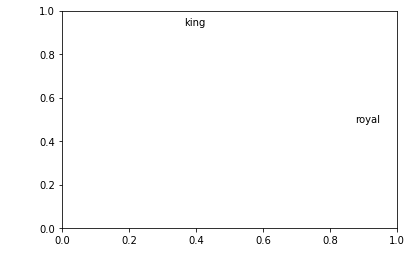

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
plt.show()